Libraries

In [2]:
# basic
import pandas as pd
import numpy as np
import pickle as pk
import os, joblib
from copy import deepcopy

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GroupKFold, KFold, GroupShuffleSplit

# pytorch
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

# XenonPy
from xenonpy.datatools import Splitter
from xenonpy.datatools.transform import Scaler
from xenonpy.utils import ParameterGenerator
from xenonpy.model import SequentialLinear
from xenonpy.model.utils import regression_metrics, classification_metrics
from xenonpy.model.training.dataset import ArrayDataset
from xenonpy.model.training import Trainer, Checker, Adam, MSELoss
from xenonpy.model.training.extension import TensorConverter, Validator, Persist

# plotting figures
import matplotlib.pyplot as plt
import seaborn as sns

# user-friendly printout
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import xenonpy
xenonpy.__version__


/home/lulab/mambaforge/envs/ML_poly/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'0.6.5'

User parameters (recorded the actual values when training the model for the paper)

In [2]:
cuda_opt = 'cuda:0' # change to cpu if not using GPU
cvtestidx = 1 # index of the set of randomly split test data stored in test_cv_idx.pkl

# data splitting
test_ratio = 0.2 # ratio of total data in computational Chi data and solubility data used for test data
n_CV_val = 5 # k-fold cross-validation for hyperparameter tuning
test_ratio_final = 0.2 # ratio of training data used for validation during final training after selection of the best hyperparameters

# hyperparameters
n_hpara = 100 # number of samples in the hyperparameter space
learning_rates = [0.001, 0.01] # range for learning rates
alpha1s = [0.0, 1.0] # range for lambda_c (can be set to zero only for 2-task model excluding PoLyInfo dataset)
alpha2s = [0.0, 1.0] # range for lambda_s (can be set to zero only for 2-task model excluding COSMO-RS dataset)
dim_outs = [3, 40] # range for dimension of Z

# model training
dir_base = f'hyper_groupCV/MT_testset_{cvtestidx}' # output directory for hyperparameter selection
n_final_model = 10 # number of retrained model ensembles after selection of the best hyperparameters

n_NNlayer = 3 # number of layer in the sub-network of fully connection MLPs
sch_step_size = 10 # step size for learning rate scheduler
sch_gamma = 0.5 # gamma parameter for learning rate scheduler
epochs_s = 0 # number of pre-training steps based on solubility data (not used in the paper)
epochs = 50 # number of max. epoch for the main training
burn_in = 1 # burn in epoch (skip this number of epoch when selecting the epoch with the lowest validation loss)

n_minibatch_PI = 20 # number of minibatch for solubility data
n_minibatch_COSMO = 10 # number of minibatch for computational Chi data
n_minibatch_CHI = 5 # number minibatch for experimental Chi data
n_factor_CHI = int(n_minibatch_PI/n_minibatch_CHI)
n_factor_COSMO = int(n_minibatch_PI/n_minibatch_COSMO)

# other internal parameters
temp_dim = 1 # take 1 or 2 only. 1: linear temperature dependence only; 2: 1/T^2 term included
loss_factor_target = 1 # multiplier to adjust target loss contribution to total loss for model training
no_target_BN = True # True: do not include experimental Chi data for batch normalization in training
no_COSMO_BN = True # True: do not include COSMO data for batch normalization in training
seed_hyper = 2022 # random seed for hyperparameter samples


### Load data

In [7]:
import pandas as pd
from copy import deepcopy
dir_load = 'sample_data'

data_PI = pd.read_csv(f'{dir_load}/data_PI.csv', index_col=0)
data_COSMO = pd.read_csv(f'{dir_load}/data_COSMO.csv', index_col=0)
data_Chi = pd.read_csv(f'{dir_load}/data_Chi.csv', index_col=0)
desc_PI = pd.read_csv(f'{dir_load}/desc_PI.csv', index_col=0)
desc_COSMO = pd.read_csv(f'{dir_load}/desc_COSMO.csv', index_col=0)
desc_Chi = pd.read_csv(f'{dir_load}/desc_Chi.csv', index_col=0)

with open(f'{dir_load}/desc_names.pkl', 'rb') as f:
    tmp = pk.load(f)
dname_p_ff = deepcopy(tmp['p_ff'])
dname_p_rd = deepcopy(tmp['p_rd'])
dname_s_ff = deepcopy(tmp['s_ff'])
dname_s_rd = deepcopy(tmp['s_rd'])

with open(f'{dir_load}/test_cv_idx.pkl', 'rb') as f:
    tmp = pk.load(f)
tmp_idx_trs = deepcopy(tmp['train'])
tmp_idx_vals = deepcopy(tmp['test'])


In [8]:
# Print the first three terms for each variable
print("data_PI (first 3 rows):")
print(data_PI.head(3))

print("\ndata_COSMO (first 3 rows):")
print(data_COSMO.head(3))

print("\ndata_Chi (first 3 rows):")
print(data_Chi.head(3))

print("\ndesc_PI (first 3 rows):")
print(desc_PI.head(3))

print("\ndesc_COSMO (first 3 rows):")
print(desc_COSMO.head(3))

print("\ndesc_Chi (first 3 rows):")
print(desc_Chi.head(3))

print("\ndname_p_ff (first 3 terms):")
print(dname_p_ff[:3])

print("\ndname_p_rd (first 3 terms):")
print(dname_p_rd[:3])

print("\ndname_s_ff (first 3 terms):")
print(dname_s_ff[:3])

print("\ndname_s_rd (first 3 terms):")
print(dname_s_rd[:3])

print("\ntmp_idx_trs (first 3 terms):")
print(tmp_idx_trs[:3])

print("\ntmp_idx_vals (first 3 terms):")
print(tmp_idx_vals[:3])

data_PI (first 3 rows):
                                             ps_pair polymer_class  soluble
0  [H]/C1=C(/Cl)C([H])([H])C([H])([H])/C([H])=C(\...   polychlorox     True
1  [H]/C1=C(/Cl)C([H])([H])C([H])([H])/C([H])=C(\...   polychlorox     True
2  [H]/C1=C(/Cl)C([H])([H])C([H])([H])/C([H])=C(\...   polychlorox     True

data_COSMO (first 3 rows):
                                             ps_pair   temp       chi  \
0  [H]/C1=C(/Cl)C([H])([H])C([H])([H])/C([H])=C(\...  100.0  0.358063   
1  [H]/C1=C(/Cl)C([H])([H])C([H])([H])/C([H])=C(\...  100.0  0.358888   
2  [H]/C1=C(/Cl)C([H])([H])C([H])([H])/C([H])=C(\...  100.0  0.327410   

  polymer_class ps_pair_nonCyclic  
0     cellulose               NaN  
1     cellulose               NaN  
2     cellulose               NaN  

data_Chi (first 3 rows):
                                             ps_pair  \
0  [H]/C1=C(/Cl)C([H])([H])C([H])([H])/C([H])=C(\...   
1  [H]/C1=C(/Cl)C([H])([H])C([H])([H])/C([H])=C(\...   
2  [H]/C1=C(/

In [4]:
import pickle as pk

# Load the pickle file
with open('sample_data/desc_names.pkl', 'rb') as f:
    data = pk.load(f)

# Function to print the first few elements of each key
def print_truncated_data(data, num_elements=5):
    for key, value in data.items():
        print(f"{key}: {value[:num_elements]}")

# Print the keys and truncated data
print("Keys:", data.keys())
print_truncated_data(data)

# Load the pickle file
with open(f'sample_data/test_cv_idx.pkl', 'rb') as f:
    data = pk.load(f)

# Function to print the first few elements of each key
def print_truncated_data(data, num_elements=5):
    for key, value in data.items():
        print(f"{key}: {value[:num_elements]}")

# Print the keys and truncated data
print("Keys:", data.keys())
print_truncated_data(data)

Keys: dict_keys(['p_ff', 'p_rd', 's_ff', 's_rd'])
p_ff: ['Polymer_mass_H' 'Polymer_mass_C' 'Polymer_mass_N' 'Polymer_mass_O'
 'Polymer_mass_F']
p_rd: ['Polymer_MaxEStateIndex' 'Polymer_MinEStateIndex'
 'Polymer_MaxAbsEStateIndex' 'Polymer_MinAbsEStateIndex' 'Polymer_qed']
s_ff: ['Solvent_mass_H' 'Solvent_mass_C' 'Solvent_mass_N' 'Solvent_mass_O'
 'Solvent_mass_F']
s_rd: ['Solvent_MaxEStateIndex' 'Solvent_MinEStateIndex'
 'Solvent_MaxAbsEStateIndex' 'Solvent_MinAbsEStateIndex' 'Solvent_qed']
Keys: dict_keys(['train', 'test'])
train: [array([   0,    1,    2,    3,    4,    6,    7,    8,    9,   11,   12,
         13,   14,   16,   17,   18,   19,   21,   22,   23,   24,   26,
         27,   29,   30,   31,   32,   34,   35,   36,   37,   39,   42,
         43,   44,   45,   46,   47,   48,   49,   52,   53,   54,   55,
         56,   57,   58,   59,   60,   61,   62,   63,   64,   65,   66,
         67,   70,   71,   74,   75,   76,   77,   78,   79,   80,   81,
         82,   83,   84

### Split data

In [4]:
# Exp-Chi data splitting
idx = cvtestidx
idx_split_t = {'idx_tr': deepcopy(tmp_idx_trs[idx]), 'idx_te': deepcopy(tmp_idx_vals[idx])}
idx_split_t['idx_tr'].shape[0], idx_split_t['idx_te'].shape[0]

# COSMO data splitting (exclude test ps_pair cases first)
idx = data_COSMO['ps_pair'].apply(lambda x: x in data_Chi['ps_pair'].loc[idx_split_t['idx_te']].values)
idx.sum()

sp_s = Splitter(size=(~idx).sum(), test_size=test_ratio, random_state=0)
_, tmp_idx = sp_s.split(idx.index[~idx].values)
idx.loc[tmp_idx] = True
idx_split_s = {'idx_tr': data_COSMO.index[~idx], 'idx_te': data_COSMO.index[idx]}
idx.sum(), (~idx).sum(), idx.sum()/idx.shape[0]*100

# PI data splitting (exclude test polymer cases first)
idx = data_PI['ps_pair'].apply(lambda x: x in data_Chi['ps_pair'].loc[idx_split_t['idx_te']].values)
idx.sum()

sp_s0 = Splitter(size=(~idx).sum(), test_size=test_ratio, random_state=0)
_, tmp_idx = sp_s0.split(idx.index[~idx].values)
idx.loc[tmp_idx] = True
idx_split_s0 = {'idx_tr': data_PI.index[~idx], 'idx_te': data_PI.index[idx]}
idx.sum(), (~idx).sum(), idx.sum()/idx.shape[0]*100


(952, 238)

241

(434, 772, 35.98673300165838)

238

(429, 761, 36.05042016806723)

### Process data for training

Scale descriptors

The code concatenates descriptor names and creates deep copies of the descriptor DataFrames.
It then concatenates the training data descriptors from the three datasets.
A custom scaler is initialized, fitted to the unique rows of the concatenated descriptors, and used to transform the descriptors in the three datasets.
This preprocessing ensures that the descriptors are scaled consistently across the datasets.

In [5]:
dname_rd = np.concatenate([dname_p_rd, dname_s_rd])
desc_s0_s = deepcopy(desc_PI)
desc_s_s = deepcopy(desc_COSMO)
desc_t_s = deepcopy(desc_Chi)

tmp_desc = pd.concat([desc_s0_s.loc[idx_split_s0['idx_tr'],dname_rd], desc_s_s.loc[idx_split_s['idx_tr'],dname_rd], desc_t_s.loc[idx_split_t['idx_tr'],dname_rd]], axis=0)
# tmp_desc = desc_t_s.loc[idx_split_t['idx_tr'],dname_rd]

x_scaler = Scaler().yeo_johnson().standard()
_ = x_scaler.fit(tmp_desc.drop_duplicates(keep='first'))
desc_s0_s[dname_rd] = x_scaler.transform(desc_s0_s[dname_rd])
desc_s_s[dname_rd] = x_scaler.transform(desc_s_s[dname_rd])
desc_t_s[dname_rd] = x_scaler.transform(desc_t_s[dname_rd])


/home/lulab/mambaforge/envs/MTL_Chi/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


Filter out constant descriptors (based on training data)

In [6]:
# filter out constant descriptors
dname_rd = np.concatenate([dname_p_rd, dname_s_rd])
tmp_desc = pd.concat([desc_s0_s.loc[idx_split_s0['idx_tr'],dname_rd], desc_s_s.loc[idx_split_s['idx_tr'],dname_rd], desc_t_s.loc[idx_split_t['idx_tr'],dname_rd]], axis=0)
dname_rd_fil = tmp_desc.columns[tmp_desc.std() != 0]
dname_p_rd_fil = np.intersect1d(dname_rd_fil, dname_p_rd)
dname_s_rd_fil = np.intersect1d(dname_rd_fil, dname_s_rd)

dname_ff = np.concatenate([dname_p_ff, dname_s_ff])
tmp_desc = pd.concat([desc_s0_s.loc[idx_split_s0['idx_tr'],dname_ff], desc_s_s.loc[idx_split_s['idx_tr'],dname_ff], desc_t_s.loc[idx_split_t['idx_tr'],dname_ff]], axis=0)
dname_ff_fil = tmp_desc.columns[tmp_desc.std() != 0]
dname_p_ff_fil = np.intersect1d(dname_ff_fil, dname_p_ff)
dname_s_ff_fil = np.intersect1d(dname_ff_fil, dname_s_ff)

dname_p = np.concatenate([dname_p_ff_fil, dname_p_rd_fil])
dname_s = np.concatenate([dname_s_ff_fil, dname_s_rd_fil])


Setup and scale y values and temperatures

In [7]:
y_s0 = data_PI[['soluble']]
y_s0.columns = ['y']
y_s = data_COSMO[['chi']]
y_s.columns = ['y']
y_t = data_Chi[['chi']]
y_t.columns = ['y']

if temp_dim == 1:
    temp_s = 1/(data_COSMO[['temp']] + 273.15)
    temp_s.columns = ['T1']
    temp_t = 1/(data_Chi[['temp']] + 273.15)
    temp_t.columns = ['T1']
elif temp_dim == 2:
    temp_s = pd.concat([1/(data_COSMO[['temp']] + 273.15), (data_COSMO[['temp']] + 273.15)**(-2)], axis=1)
    temp_s.columns = ['T1', 'T2']
    temp_t = pd.concat([1/(data_Chi[['temp']] + 273.15), (data_Chi[['temp']] + 273.15)**(-2)], axis=1)
    temp_t.columns = ['T1', 'T2']


In [8]:
# ys_scaler = Scaler().min_max((-1,1))
ys_scaler = Scaler().standard()
_ = ys_scaler.fit(y_s.loc[idx_split_s['idx_tr']].reset_index(drop=True))
y_s_s = ys_scaler.transform(y_s)

# yt_scaler = Scaler().min_max((-1,1))
yt_scaler = Scaler().standard()
_ = yt_scaler.fit(y_t.loc[idx_split_t['idx_tr']].reset_index(drop=True))
y_t_s = yt_scaler.transform(y_t)


In [9]:
# temp_scaler = Scaler().min_max((-1,1))
tempS_scaler = Scaler().standard()
_ = tempS_scaler.fit(temp_s.loc[idx_split_s['idx_tr'],:])
temp_s_s = tempS_scaler.transform(temp_s)

tempT_scaler = Scaler().standard()
_ = tempT_scaler.fit(temp_t.loc[idx_split_t['idx_tr'],:])
temp_t_s = tempT_scaler.transform(temp_t)


### Build model

In [10]:
# fixed linearly reducing pyramid shape
def neuron_vector(nL, in_neu, out_neu):
    return [int(x) for x in np.rint(np.linspace(in_neu, out_neu, nL+2))[1:-1]]

# module of the final NN
if temp_dim == 1:
    class Chi_Model(nn.Module):
        def __init__(self, sp_mdl_p, sp_mdl_s, dim_ur):
            super(Chi_Model, self).__init__()

            self.network1 = deepcopy(sp_mdl_p)
            self.network2 = deepcopy(sp_mdl_s)

            self.out_lin = nn.Linear(dim_ur, 5)
            self.out_act = nn.Sigmoid()
            self.dim_ur = dim_ur

        def forward(self, x1, x2, temp):
            ur1 = self.network1(x1)
            ur2 = self.network2(x2)

            sp = (ur1[:,:self.dim_ur] - ur2[:,:self.dim_ur])**2
            r1 = ur1[:,self.dim_ur:]**2
            r2 = ur2[:,self.dim_ur:]**2

            z0 = sp - r1 - r2
            z = self.out_lin(z0)

            z_soluble = self.out_act(z[:,0:1])

            As = z[:,1:2]
            Bs = z[:,2:3]
            z_comp = As + Bs*temp[:,0:1]

            At = z[:,3:4]
            Bt = z[:,4:5]
            z_target = At + Bt*temp[:,0:1]

            y = torch.cat((z_soluble, z_comp, z_target, z, z0), dim=1)

            return y
        
elif temp_dim == 2:
    class Chi_Model(nn.Module):
        def __init__(self, sp_mdl_p, sp_mdl_s, dim_ur):
            super(Chi_Model, self).__init__()

            self.network1 = deepcopy(sp_mdl_p)
            self.network2 = deepcopy(sp_mdl_s)

            self.out_lin = nn.Linear(dim_ur, 7)
            self.out_act = nn.Sigmoid()
            self.dim_ur = dim_ur

        def forward(self, x1, x2, temp):
            ur1 = self.network1(x1)
            ur2 = self.network2(x2)

            sp = (ur1[:,:self.dim_ur] - ur2[:,:self.dim_ur])**2
            r1 = ur1[:,self.dim_ur:]**2
            r2 = ur2[:,self.dim_ur:]**2

            z0 = sp - r1 - r2
            z = self.out_lin(z0)

            z_soluble = self.out_act(z[:,0:1])

            As = z[:,1:2]
            Bs = z[:,2:3]
            Cs = z[:,3:4]
            z_comp = As + Bs*temp[:,0:1] + Cs*temp[:,1:2]

            At = z[:,4:5]
            Bt = z[:,5:6]
            Ct = z[:,6:7]
            z_target = At + Bt*temp[:,0:1] + Ct*temp[:,1:2]

            y = torch.cat((z_soluble, z_comp, z_target, z, z0), dim=1)

            return y
    

In [11]:
# functions to save and load the NN model
def save_NN(paras_p, paras_s, dim_out, c_mdl, file_name):
    torch.save({'model_p': paras_p, 'model_s': paras_s, 'chi': c_mdl.state_dict(), 'dim_out': dim_out}, file_name)
    
def load_NN(file_name):
    tmp_paras = torch.load(file_name)
    c_model = Chi_Model(SequentialLinear(**tmp_paras['model_p']), SequentialLinear(**tmp_paras['model_s']), tmp_paras['dim_out'])
    _ = c_model.load_state_dict(tmp_paras['chi'])
    return c_model


### Hyperparameter tuning with grid search and CV

Group validation

In [12]:
poly_group = data_Chi.loc[idx_split_t['idx_tr'],'ps_pair']

gp_cv = GroupKFold(n_splits=n_CV_val)
idx_trs, idx_vals = [], []

np.random.seed(0)
for idx_tr, idx_val in gp_cv.split(y_t['y'].loc[idx_split_t['idx_tr']], groups=poly_group.to_list()):
    idx_trs.append(y_t['y'].loc[idx_split_t['idx_tr']].iloc[idx_tr].index.values)
    idx_vals.append(y_t['y'].loc[idx_split_t['idx_tr']].iloc[idx_val].index.values)


Prepare for training

In [13]:
criterion_source0 = nn.BCELoss()
criterion_source = nn.MSELoss()
criterion_target = nn.MSELoss()

dim_in_p = len(dname_p)
dim_in_s = len(dname_s)

np.random.seed(seed_hyper)
hyper_para = pd.DataFrame({'alpha1': np.random.uniform(alpha1s[0], alpha1s[1], n_hpara), 
                           'alpha2': np.random.uniform(alpha2s[0], alpha2s[1], n_hpara),
                           'dim_out': np.random.randint(dim_outs[0], dim_outs[1], n_hpara),
                           'lr': np.random.uniform(learning_rates[0], learning_rates[1], n_hpara)})

os.makedirs(dir_base, exist_ok=True)
hyper_para.to_csv(f'{dir_base}/list_hyperparameters.csv')

XS0_P_TE = torch.tensor(desc_s0_s.loc[idx_split_s0['idx_te'], dname_p].values.astype("float"), dtype=torch.float32, device=cuda_opt)
XS0_S_TE = torch.tensor(desc_s0_s.loc[idx_split_s0['idx_te'], dname_s].values.astype("float"), dtype=torch.float32, device=cuda_opt)
XS0_T_TE = torch.zeros(idx_split_s0['idx_te'].shape[0], temp_dim, device=cuda_opt)
YS0_TE = torch.tensor(y_s0.loc[idx_split_s0['idx_te'], :].values.astype("float"), dtype=torch.float32, device=cuda_opt)

XS_P_TE = torch.tensor(desc_s_s.loc[idx_split_s['idx_te'], dname_p].values.astype("float"), dtype=torch.float32, device=cuda_opt)
XS_S_TE = torch.tensor(desc_s_s.loc[idx_split_s['idx_te'], dname_s].values.astype("float"), dtype=torch.float32, device=cuda_opt)
XS_T_TE = torch.tensor(temp_s_s.loc[idx_split_s['idx_te'], :].values.astype("float"), dtype=torch.float32, device=cuda_opt)
YS_TE = torch.tensor(y_s_s.loc[idx_split_s['idx_te'], :].values.astype("float"), dtype=torch.float32, device=cuda_opt)

XT_P_TE = torch.tensor(desc_t_s.loc[idx_split_t['idx_te'], dname_p].values.astype("float"), dtype=torch.float32, device=cuda_opt)
XT_S_TE = torch.tensor(desc_t_s.loc[idx_split_t['idx_te'], dname_s].values.astype("float"), dtype=torch.float32, device=cuda_opt)
XT_T_TE = torch.tensor(temp_t_s.loc[idx_split_t['idx_te'], :].values.astype("float"), dtype=torch.float32, device=cuda_opt)
YT_TE = torch.tensor(y_t_s.loc[idx_split_t['idx_te'], :].values.astype("float"), dtype=torch.float32, device=cuda_opt)

XS0_P_TR = torch.tensor(desc_s0_s.loc[idx_split_s0['idx_tr'], dname_p].values.astype("float"), dtype=torch.float32, device=cuda_opt)
XS0_S_TR = torch.tensor(desc_s0_s.loc[idx_split_s0['idx_tr'], dname_s].values.astype("float"), dtype=torch.float32, device=cuda_opt)
XS0_T_TR = torch.zeros(idx_split_s0['idx_tr'].shape[0], temp_dim, device=cuda_opt)
YS0_TR = torch.tensor(y_s0.loc[idx_split_s0['idx_tr'], :].values.astype("float"), dtype=torch.float32, device=cuda_opt)

XS_P_TR = torch.tensor(desc_s_s.loc[idx_split_s['idx_tr'], dname_p].values.astype("float"), dtype=torch.float32, device=cuda_opt)
XS_S_TR = torch.tensor(desc_s_s.loc[idx_split_s['idx_tr'], dname_s].values.astype("float"), dtype=torch.float32, device=cuda_opt)
XS_T_TR = torch.tensor(temp_s_s.loc[idx_split_s['idx_tr'], :].values.astype("float"), dtype=torch.float32, device=cuda_opt)
YS_TR = torch.tensor(y_s_s.loc[idx_split_s['idx_tr'], :].values.astype("float"), dtype=torch.float32, device=cuda_opt)


Training models

In [14]:
%%time

np.random.seed(0)

for iCV, (idx_tr, idx_val) in enumerate(zip(idx_trs, idx_vals)):
    XT_P_TR = torch.tensor(desc_t_s.loc[idx_tr, dname_p].values.astype("float"), dtype=torch.float32, device=cuda_opt)
    XT_S_TR = torch.tensor(desc_t_s.loc[idx_tr, dname_s].values.astype("float"), dtype=torch.float32, device=cuda_opt)
    XT_T_TR = torch.tensor(temp_t_s.loc[idx_tr, :].values.astype("float"), dtype=torch.float32, device=cuda_opt)
    YT_TR = torch.tensor(y_t_s.loc[idx_tr, :].values.astype("float"), dtype=torch.float32, device=cuda_opt)

    XT_P_VA = torch.tensor(desc_t_s.loc[idx_val, dname_p].values.astype("float"), dtype=torch.float32, device=cuda_opt)
    XT_S_VA = torch.tensor(desc_t_s.loc[idx_val, dname_s].values.astype("float"), dtype=torch.float32, device=cuda_opt)
    XT_T_VA = torch.tensor(temp_t_s.loc[idx_val, :].values.astype("float"), dtype=torch.float32, device=cuda_opt)
    YT_VA = torch.tensor(y_t_s.loc[idx_val, :].values.astype("float"), dtype=torch.float32, device=cuda_opt)

    for ii, h_paras in hyper_para.iterrows():
        alpha1 = h_paras['alpha1']
        alpha2 = h_paras['alpha2']
        dim_out = int(h_paras['dim_out'])
        learning_rate = h_paras['lr']

        generator_p = ParameterGenerator(
            in_features=dim_in_p,
            out_features=dim_out*2,
            h_neurons=dict(
                data=lambda x: neuron_vector(x, dim_in_p, dim_out*2), 
                repeat=[n_NNlayer]
            ),
            h_activation_funcs=(nn.Sigmoid(), ),
            h_dropouts=(0.0,)
        )

        generator_s = ParameterGenerator(
            in_features=dim_in_s,
            out_features=dim_out*2,
            h_neurons=dict(
                data=lambda x: neuron_vector(x, dim_in_s, dim_out*2), 
                repeat=[n_NNlayer]
            ),
            h_activation_funcs=(nn.Sigmoid(), ),
            h_dropouts=(0.0,)
        )
        
        for iM, ((paras_p, model_p), (paras_s, model_s)) in enumerate(zip(generator_p(num=1, factory=SequentialLinear), generator_s(num=1, factory=SequentialLinear))):
            dir_save = f'{dir_base}/cv{iCV}/hpara{ii}'
            os.makedirs(dir_save, exist_ok=True)

            c_model = Chi_Model(model_p, model_s, dim_out)
            c_model.to(cuda_opt)

            c_model.train()

            optimizer = optim.Adam(c_model.parameters(), lr=learning_rate, amsgrad=True)
            scheduler = StepLR(optimizer, step_size=sch_step_size, gamma=sch_gamma)

            learning_curve = pd.DataFrame()

            for t in range(epochs_s):
                # mini-batch of training data
                kf = KFold(n_splits=n_minibatch_PI, shuffle=True)
                idx_mb_s0 = [x for _, x in kf.split(XS0_P_TR)]

                # pre-training with PI
                for tt, ii_s0 in enumerate(idx_mb_s0):
                    c_model.train()

                    tmp_source0_train = c_model(XS0_P_TR[ii_s0,:], XS0_S_TR[ii_s0,:], XS0_T_TR[ii_s0,:])
                    py_source0_train = tmp_source0_train[:,0:1]
                    loss_source0_train = criterion_source0(py_source0_train, YS0_TR[ii_s0,:])

                    optimizer.zero_grad()
                    loss_source0_train.backward()
                    optimizer.step()

                    c_model.eval()
                    with torch.no_grad():
                        py_source_train = c_model(XS_P_TR, XS_S_TR, XS_T_TR)[:,1:2]
                        py_target_train = c_model(XT_P_TR, XT_S_TR, XT_T_TR)[:,2:3]
                        loss_source_train = criterion_source(py_source_train, YS_TR)
                        loss_target_train = criterion_target(py_target_train, YT_TR)*loss_factor_target
                        loss_train = alpha1*loss_source0_train + (1.0-alpha1)*(alpha2*loss_source_train + (1.0-alpha2)*loss_target_train)

                        py_target_val = c_model(XT_P_VA, XT_S_VA, XT_T_VA)[:,1:2]
                        loss_target_val = criterion_target(py_target_val, YT_VA)*loss_factor_target

                        py_source0_test = c_model(XS0_P_TE, XS0_S_TE, XS0_T_TE)[:,0:1]
                        py_source_test = c_model(XS_P_TE, XS_S_TE, XS_T_TE)[:,1:2]
                        py_target_test = c_model(XT_P_TE, XT_S_TE, XT_T_TE)[:,2:3]
                        loss_source0_test = criterion_source0(py_source0_test, YS0_TE)
                        loss_source_test = criterion_source(py_source_test, YS_TE)
                        loss_target_test = criterion_target(py_target_test, YT_TE)*loss_factor_target
                        loss_test = alpha1*loss_source0_test + (1.0-alpha1)*(alpha2*loss_source_test + (1.0-alpha2)*loss_target_test)

                    learning_curve = pd.concat([learning_curve, pd.Series({
                                            "Loss_Source0_Training": loss_source0_train.item(), 
                                            "Loss_Source0_Test": loss_source0_test.item(),
                                            "Loss_Source_Training": loss_source_train.item(), 
                                            "Loss_Source_Test": loss_source_test.item(),
                                            "Loss_Target_Training": loss_target_train.item(),
                                            "Loss_Target_Validation":loss_target_val.item(),
                                            "Loss_Target_Test":loss_target_test.item(),
                                            "Loss_Training":loss_train.item(),
                                            "Loss_Test":loss_test.item()},
                                           name=f'pre_{t}').to_frame().T], axis=0)

            # main training
            best_loss_val = np.inf
            for t in range(epochs):
                # mini-batch of training data
                kf = KFold(n_splits=n_minibatch_PI, shuffle=True)
                idx_mb_s0 = [x for _, x in kf.split(XS0_P_TR)]
                idx_mb_s, idx_mb_t = [], []
                for k in range(n_factor_COSMO):
                    kf = KFold(n_splits=n_minibatch_COSMO, shuffle=True)
                    idx_mb_s += [x for _, x in kf.split(XS_P_TR)]
                for k in range(n_factor_CHI):
                    kf = KFold(n_splits=n_minibatch_CHI, shuffle=True)
                    idx_mb_t += [x for _, x in kf.split(XT_P_TR)]

                for tt, (ii_s0, ii_s, ii_t) in enumerate(zip(idx_mb_s0, idx_mb_s, idx_mb_t)):
                    c_model.train()
                    if alpha1 > 0:
                        py_source0_train = c_model(XS0_P_TR[ii_s0,:], XS0_S_TR[ii_s0,:], XS0_T_TR[ii_s0,:])[:,0:1]
                        loss_source0_train = criterion_source0(py_source0_train, YS0_TR[ii_s0,:])
                    else:
                        loss_source0_train = torch.zeros(1, device=cuda_opt)

                    if (alpha2 > 0) and (alpha1 < 1):
                        if no_COSMO_BN:
                            c_model.eval()
                        else:
                            c_model.train()
                        py_source_train = c_model(XS_P_TR[ii_s,:], XS_S_TR[ii_s,:], XS_T_TR[ii_s,:])[:,1:2]
                        loss_source_train = criterion_source(py_source_train, YS_TR[ii_s,:])
                    else:
                        loss_source_train = torch.zeros(1, device=cuda_opt)

                    if (alpha1 < 1) and (alpha2 < 1):
                        if no_target_BN:
                            c_model.eval()
                        else:
                            c_model.train()
                        py_target_train = c_model(XT_P_TR[ii_t,:], XT_S_TR[ii_t,:], XT_T_TR[ii_t,:])[:,2:3]
                        loss_target_train = criterion_target(py_target_train, YT_TR[ii_t,:])*loss_factor_target
                    else:
                        loss_target_train = torch.zeros(1, device=cuda_opt)

                    loss_train = alpha1*loss_source0_train + (1.0-alpha1)*(alpha2*loss_source_train + (1.0-alpha2)*loss_target_train)

                    optimizer.zero_grad()
                    loss_train.backward()
                    optimizer.step()

                    c_model.eval()
                    with torch.no_grad():
                        py_target_val = c_model(XT_P_VA, XT_S_VA, XT_T_VA)[:,2:3]
                        loss_target_val = criterion_target(py_target_val, YT_VA)*loss_factor_target

                        py_source0_test = c_model(XS0_P_TE, XS0_S_TE, XS0_T_TE)[:,0:1]
                        py_source_test = c_model(XS_P_TE, XS_S_TE, XS_T_TE)[:,1:2]
                        py_target_test = c_model(XT_P_TE, XT_S_TE, XT_T_TE)[:,2:3]
                        loss_source0_test = criterion_source0(py_source0_test, YS0_TE)
                        loss_source_test = criterion_source(py_source_test, YS_TE)
                        loss_target_test = criterion_target(py_target_test, YT_TE)*loss_factor_target
                        loss_test = alpha1*loss_source0_test + (1.0-alpha1)*(alpha2*loss_source_test + (1.0-alpha2)*loss_target_test)

                    learning_curve = pd.concat([learning_curve, pd.Series({
                                            "Loss_Source0_Training": loss_source0_train.item(), 
                                            "Loss_Source0_Test": loss_source0_test.item(),
                                            "Loss_Source_Training": loss_source_train.item(), 
                                            "Loss_Source_Test": loss_source_test.item(),
                                            "Loss_Target_Training": loss_target_train.item(),
                                            "Loss_Target_Validation":loss_target_val.item(),
                                            "Loss_Target_Test":loss_target_test.item(),
                                            "Loss_Training":loss_train.item(),
                                            "Loss_Test":loss_test.item()},
                                           name=f'main_{t}_{tt}').to_frame().T], axis=0)

                    if (t > burn_in) and (loss_target_val < best_loss_val):
                        save_NN(paras_p, paras_s, dim_out, c_model, f'{dir_save}/best_loss_target_val.pt')

                        with torch.no_grad():
                            py_source0_train = c_model(XS0_P_TR, XS0_S_TR, XS0_T_TR)[:,0:1]
                            py_source_train = c_model(XS_P_TR, XS_S_TR, XS_T_TR)[:,1:2]
                            py_target_train = c_model(XT_P_TR, XT_S_TR, XT_T_TR)[:,2:3]
                        pd.concat([y_s0.loc[idx_split_s0['idx_tr'],:], pd.Series(py_source0_train.to('cpu').detach().numpy().flatten(), index=idx_split_s0['idx_tr'], name='pred')] , axis=1
                                 ).to_csv(f'{dir_save}/best_loss_target_val_source0_train.csv')
                        pd.concat([y_s.loc[idx_split_s['idx_tr'],:], pd.Series(ys_scaler.inverse_transform(py_source_train.to('cpu').detach().numpy()).flatten(), index=idx_split_s['idx_tr'], name='pred')] , axis=1
                                 ).to_csv(f'{dir_save}/best_loss_target_val_source_train.csv')
                        pd.concat([y_t.loc[idx_tr,:], pd.Series(yt_scaler.inverse_transform(py_target_train.to('cpu').detach().numpy()).flatten(), index=idx_tr, name='pred')] , axis=1
                                 ).to_csv(f'{dir_save}/best_loss_target_val_target_train.csv')

                        pd.concat([y_t.loc[idx_val,:], pd.Series(yt_scaler.inverse_transform(py_target_val.to('cpu').detach().numpy()).flatten(), index=idx_val, name='pred')] , axis=1
                                 ).to_csv(f'{dir_save}/best_loss_target_val_target_val.csv')

                        pd.concat([y_s0.loc[idx_split_s0['idx_te'],:], pd.Series(py_source0_test.to('cpu').detach().numpy().flatten(), index=idx_split_s0['idx_te'], name='pred')] , axis=1
                                 ).to_csv(f'{dir_save}/best_loss_target_val_source0_test.csv')
                        pd.concat([y_s.loc[idx_split_s['idx_te'],:], pd.Series(ys_scaler.inverse_transform(py_source_test.to('cpu').detach().numpy()).flatten(), index=idx_split_s['idx_te'], name='pred')] , axis=1
                                 ).to_csv(f'{dir_save}/best_loss_target_val_source_test.csv')
                        pd.concat([y_t.loc[idx_split_t['idx_te'],:], pd.Series(yt_scaler.inverse_transform(py_target_test.to('cpu').detach().numpy()).flatten(), index=idx_split_t['idx_te'], name='pred')] , axis=1
                                 ).to_csv(f'{dir_save}/best_loss_target_val_target_test.csv')
                        
                        best_loss_val = loss_target_val

                scheduler.step()

            learning_curve.to_csv(f'{dir_save}/learning_curve.csv')

    print(f'Finished model {iCV}')


Finished model 0
Finished model 1
Finished model 2
Finished model 3
Finished model 4
CPU times: user 4h 22min 1s, sys: 9min 26s, total: 4h 31min 28s
Wall time: 3h 39min 7s


### Extract CV results

In [15]:
%%time

# dir_load = f'hyper_groupCV/testset_{cvtestidx}'
dir_load = dir_base
dir_load = [x for x in os.listdir(dir_base) if x[:2]=='cv']
dir_load.sort(key=lambda item: int(item[2:]))

hyper_para = pd.read_csv(f'{dir_base}/list_hyperparameters.csv', index_col=0)
x_lim_range = [0, epochs*n_minibatch_PI] # plot only main training parts

df_summary = pd.DataFrame()
for dirL in dir_load:
    mdl_list = [x for x in os.listdir(f'{dir_base}/{dirL}') if x[:5]=='hpara']
    mdl_list.sort(key=lambda item: int(item[5:]))
    for fn in mdl_list:
        learning_curve = pd.read_csv(f'{dir_base}/{dirL}/{fn}/learning_curve.csv', index_col=0)
        idx_list = [x for x in learning_curve.index if (x[:5] == 'main_') and (int(x.split('_')[1]) >= burn_in)]
        idx = learning_curve['Loss_Target_Validation'].loc[idx_list].idxmin()
        tmp_row = learning_curve.loc[idx,:].rename(f'{dirL}_{fn}').to_frame().T
        tmp_row['cv'] = int(dirL[2:])
        tmp_row['n_epoch'] = int(idx.split('_')[1])
        tmp_row['hpara'] = int(fn[5:])
        tmp_row[hyper_para.columns] = hyper_para.loc[tmp_row['hpara'],:].values
        df_summary = pd.concat([df_summary, tmp_row], axis=0)
        
        # plot learning curves
        best_t = int(idx.split('_')[1])*n_minibatch_PI + int(idx.split('_')[2])
        
        _ = plt.xlabel("epoch")
        _ = plt.ylabel("Target loss")
        _ = plt.plot(learning_curve["Loss_Target_Training"].values, label="Training")
        _ = plt.plot(learning_curve["Loss_Target_Validation"].values, label="Validation")
        _ = plt.plot(learning_curve["Loss_Target_Test"].values, label="Test")
        _ = plt.axvline(x = best_t, color = 'r', ls='--')
        _ = plt.xlim(x_lim_range)
        _ = plt.ylim([0, 1])
        _ = plt.legend()
        _ = plt.savefig(f'{dir_base}/{dirL}/{fn}/LearningCurve_TargetLoss.png')
        # _ = plt.show()
        _ = plt.close()

        _ = plt.xlabel("epoch")
        _ = plt.ylabel("Source loss")
        _ = plt.plot(learning_curve["Loss_Source_Training"].values, label="Training")
        _ = plt.plot(learning_curve["Loss_Source_Test"].values, label="Test")
        _ = plt.axvline(x = best_t, color = 'r', ls='--')
        _ = plt.xlim(x_lim_range)
        _ = plt.ylim([0, 1])
        _ = plt.legend()
        _ = plt.savefig(f'{dir_base}/{dirL}/{fn}/LearningCurve_SourceLoss.png')
        # _ = plt.show()
        _ = plt.close()

        _ = plt.xlabel("epoch")
        _ = plt.ylabel("Target loss")
        _ = plt.plot(learning_curve["Loss_Source0_Training"].values, label="Training")
        _ = plt.plot(learning_curve["Loss_Source0_Test"].values, label="Test")
        _ = plt.axvline(x = best_t, color = 'r', ls='--')
        _ = plt.xlim(x_lim_range)
        _ = plt.ylim([0, 1])
        _ = plt.legend()
        _ = plt.savefig(f'{dir_base}/{dirL}/{fn}/LearningCurve_Source0Loss.png')
        # _ = plt.show()
        _ = plt.close()
        
        # plot predictions
        df_source0_train = pd.read_csv(f'{dir_base}/{dirL}/{fn}/best_loss_target_val_source0_train.csv', index_col=0)
        df_source0_test = pd.read_csv(f'{dir_base}/{dirL}/{fn}/best_loss_target_val_source0_test.csv', index_col=0)
        df_source_train = pd.read_csv(f'{dir_base}/{dirL}/{fn}/best_loss_target_val_source_train.csv', index_col=0)
        df_source_test = pd.read_csv(f'{dir_base}/{dirL}/{fn}/best_loss_target_val_source_test.csv', index_col=0)
        df_target_train = pd.read_csv(f'{dir_base}/{dirL}/{fn}/best_loss_target_val_target_train.csv', index_col=0)
        df_target_val = pd.read_csv(f'{dir_base}/{dirL}/{fn}/best_loss_target_val_target_val.csv', index_col=0)
        df_target_test = pd.read_csv(f'{dir_base}/{dirL}/{fn}/best_loss_target_val_target_test.csv', index_col=0)
        pd.DataFrame(confusion_matrix(df_source0_train['y'], df_source0_train['pred']>0.5)).to_csv(f'{dir_base}/{dirL}/{fn}/confusion_matrix_train.csv')
        pd.DataFrame(confusion_matrix(df_source0_test['y'], df_source0_test['pred']>0.5)).to_csv(f'{dir_base}/{dirL}/{fn}/confusion_matrix_test.csv')
        pd.DataFrame(classification_metrics(df_source0_train['y'].values, (df_source0_train['pred']>0.5).values, average='binary')).to_csv(f'{dir_base}/{dirL}/{fn}/classification_metrics_train.csv')
        pd.DataFrame(classification_metrics(df_source0_test['y'].values, (df_source0_test['pred']>0.5).values, average='binary')).to_csv(f'{dir_base}/{dirL}/{fn}/classification_metrics_test.csv')

        _ = plt.figure()
        _ = plt.xlabel("Prediction")
        _ = plt.ylabel("Observation")
        _ = plt.scatter(df_source_train['pred'], df_source_train['y'], c='b', alpha=0.4, label="Train")
        _ = plt.scatter(df_source_test['pred'], df_source_test['y'], c='r', alpha=0.4, label="Test")
        xy_min = min(df_source_test.min().min(), df_source_train.min().min())
        xy_max = max(df_source_test.max().max(), df_source_train.max().max())
        _ = plt.plot([xy_min, xy_max], [xy_min, xy_max], color = 'k', ls='--', alpha=0.5)
        _ = plt.legend()
        _ = plt.savefig(f'{dir_base}/{dirL}/{fn}/P2O_BestVal_Source.png')
        # _ = plt.show()
        _ = plt.close()

        source_summary = pd.concat([pd.DataFrame.from_dict(regression_metrics(df_source_train['y'].values, df_source_train['pred'].values), orient='index'),
            pd.DataFrame.from_dict(regression_metrics(df_source_test['y'].values, df_source_test['pred'].values), orient='index')], axis=1)
        source_summary.columns = ['train', 'test']
        source_summary.to_csv(f'{dir_base}/{dirL}/{fn}/PredSummary_BestVal_Source.csv')
        
        _ = plt.figure()
        _ = plt.xlabel("Prediction")
        _ = plt.ylabel("Observation")
        _ = plt.scatter(df_target_train['pred'], df_target_train['y'], c='b', alpha=0.2, label="Train")
        _ = plt.scatter(df_target_val['pred'], df_target_val['y'], c='g', alpha=0.3, label="Val")
        _ = plt.scatter(df_target_test['pred'], df_target_test['y'], c='r', alpha=0.4, label="Test")
        xy_min = min(df_target_test.min().min(), df_target_val.min().min(), df_target_train.min().min())
        xy_max = max(df_target_test.max().max(), df_target_val.max().max(), df_target_train.max().max())
        _ = plt.plot([xy_min, xy_max], [xy_min, xy_max], color = 'k', ls='--', alpha=0.5)
        _ = plt.legend()
        _ = plt.savefig(f'{dir_base}/{dirL}/{fn}/P2O_BestVal_Target.png')
        # _ = plt.show()
        _ = plt.close()

        target_summary = pd.concat([pd.DataFrame.from_dict(regression_metrics(df_target_train['y'].values, df_target_train['pred'].values), orient='index'),
            pd.DataFrame.from_dict(regression_metrics(df_target_val['y'].values, df_target_val['pred'].values), orient='index'),
            pd.DataFrame.from_dict(regression_metrics(df_target_test['y'].values, df_target_test['pred'].values), orient='index')], axis=1)
        target_summary.columns = ['train', 'val', 'test']
        target_summary.to_csv(f'{dir_base}/{dirL}/{fn}/PredSummary_BestVal_Target.csv')
        
df_summary.sort_values(by='Loss_Target_Validation')
df_summary.groupby('hpara').median().sort_values('Loss_Target_Validation')
df_summary.groupby('hpara').std().sort_values('Loss_Target_Validation')


CPU times: user 5min 12s, sys: 5.83 s, total: 5min 18s
Wall time: 5min 18s


,Loss_Source0_Training,Loss_Source0_Test,Loss_Source_Training,Loss_Source_Test,Loss_Target_Training,Loss_Target_Validation,Loss_Target_Test,Loss_Training,Loss_Test,cv,n_epoch,alpha1,alpha2,dim_out,lr
hpara,,,,,,,,,,,,,,,
71,0.092076,0.026720,0.126856,0.051522,0.087113,0.012899,0.030204,0.067684,0.027541,1.581139,11.895377,0.0,0.0,0.0,0.0
59,0.099002,0.019033,0.040924,0.037459,0.039498,0.019025,0.040501,0.088299,0.014879,1.581139,11.233877,0.0,0.0,0.0,0.0
99,0.035304,0.026937,0.043294,0.044367,0.016630,0.019760,0.039081,0.016185,0.037716,1.581139,15.264338,0.0,0.0,0.0,0.0
15,0.070400,0.005250,0.014880,0.030857,0.011890,0.019941,0.062875,0.040083,0.028199,1.581139,10.430724,0.0,0.0,0.0,0.0
58,0.056191,0.008990,0.006795,0.046439,0.020421,0.021519,0.068896,0.029728,0.038650,1.581139,6.058052,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,0.055096,0.018206,0.045463,0.085002,0.031868,0.083206,0.104398,0.030200,0.096170,1.581139,13.379088,0.0,0.0,0.0,0.0
55,0.144341,0.071062,0.150785,0.139303,0.126658,0.096708,0.152091,0.118523,0.117945,1.581139,3.807887,0.0,0.0,0.0,0.0
66,0.064139,0.022760,0.175185,0.253091,0.090823,0.103679,0.072136,0.064181,0.023403,1.581139,7.582875,0.0,0.0,0.0,0.0


Plot CV training results

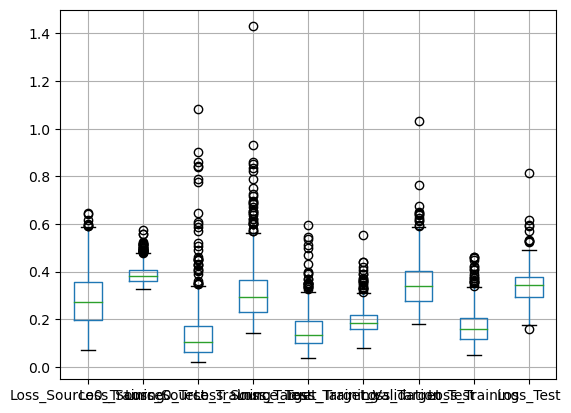

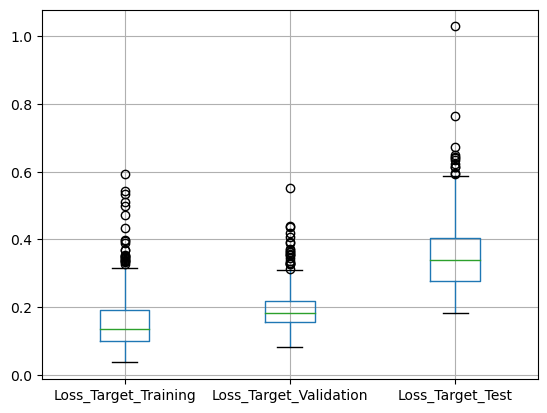

In [16]:
_ = plt.figure()
_ = df_summary.iloc[:,:9].boxplot()
_ = plt.figure()
_ = df_summary.iloc[:,4:7].boxplot()


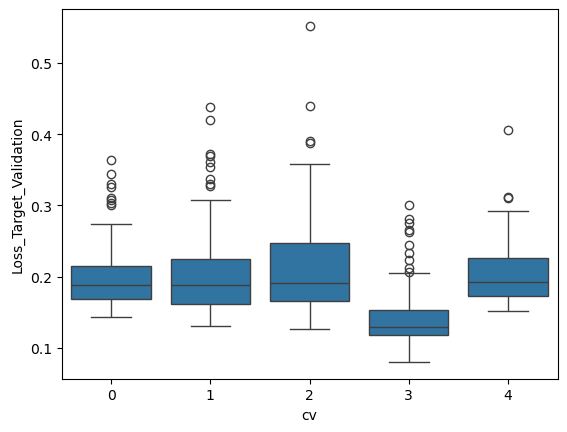

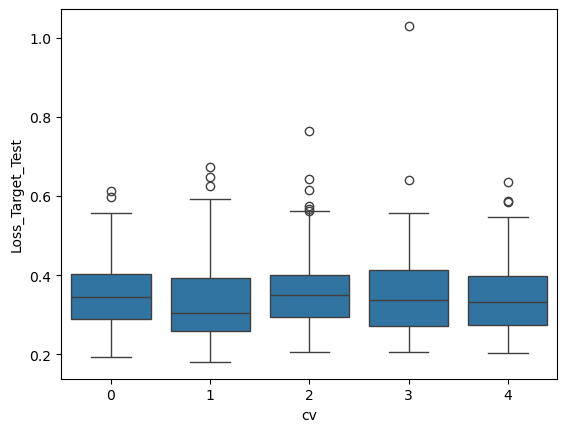

In [17]:
_ = plt.figure()
_ = sns.boxplot(data=df_summary, x='cv', y='Loss_Target_Validation')
_ = plt.figure()
_ = sns.boxplot(data=df_summary, x='cv', y='Loss_Target_Test')


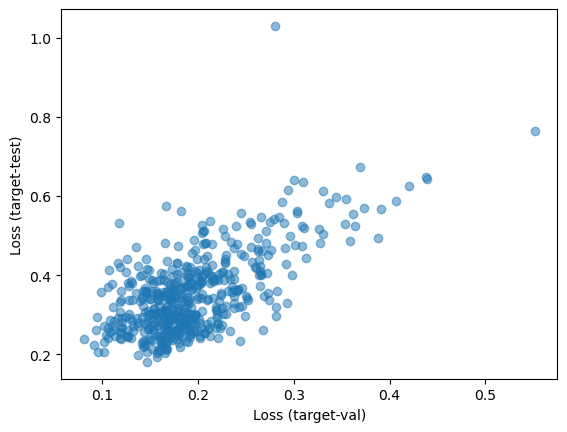

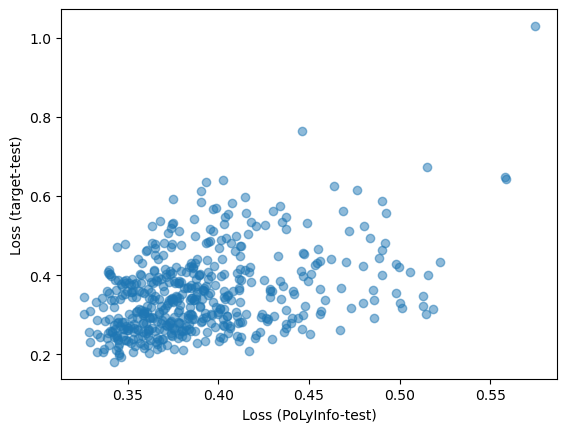

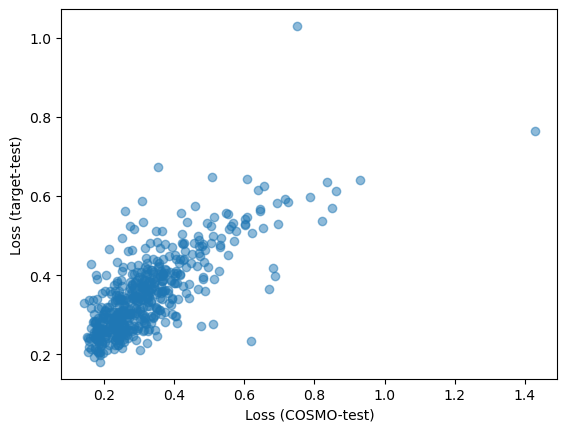

In [18]:
_ = plt.figure()
_ = plt.scatter(df_summary['Loss_Target_Validation'].values, df_summary['Loss_Target_Test'].values, alpha=0.5)
_ = plt.xlabel('Loss (target-val)')
_ = plt.ylabel('Loss (target-test)')

_ = plt.figure()
_ = plt.scatter(df_summary['Loss_Source0_Test'].values, df_summary['Loss_Target_Test'].values, alpha=0.5)
_ = plt.xlabel('Loss (PoLyInfo-test)')
_ = plt.ylabel('Loss (target-test)')

_ = plt.figure()
_ = plt.scatter(df_summary['Loss_Source_Test'].values, df_summary['Loss_Target_Test'].values, alpha=0.5)
_ = plt.xlabel('Loss (COSMO-test)')
_ = plt.ylabel('Loss (target-test)')


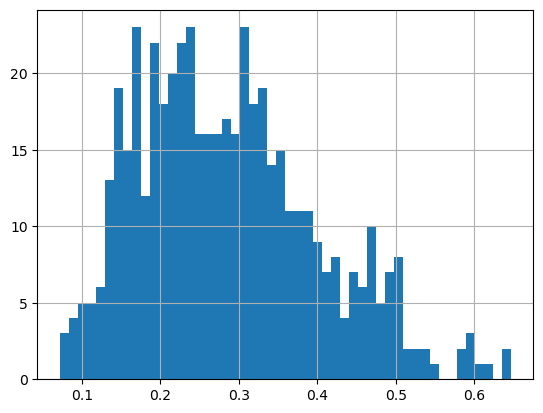

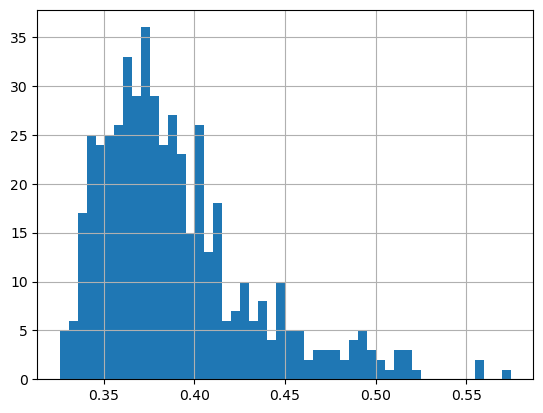

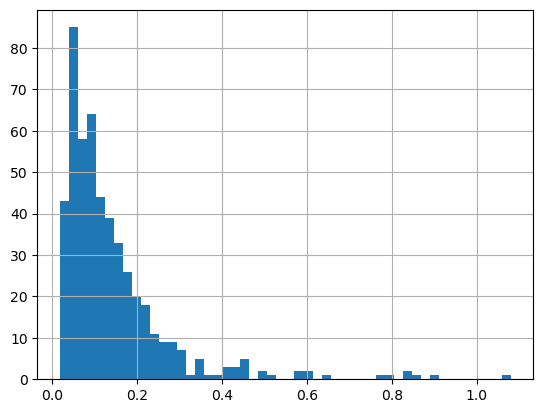

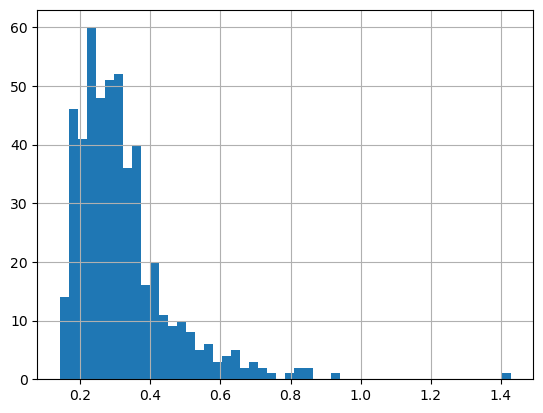

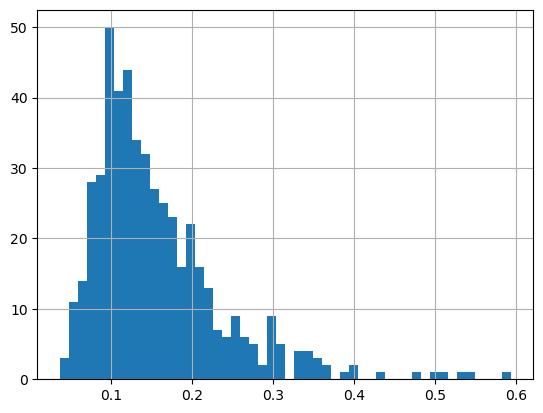

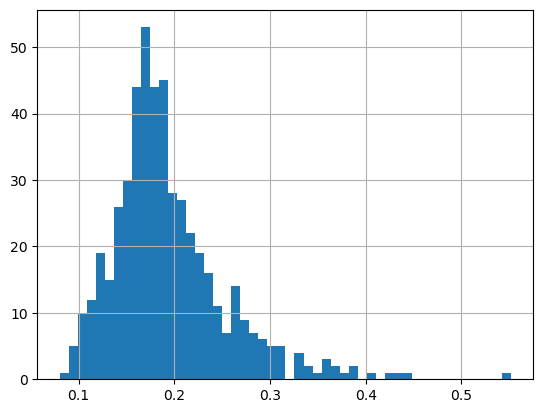

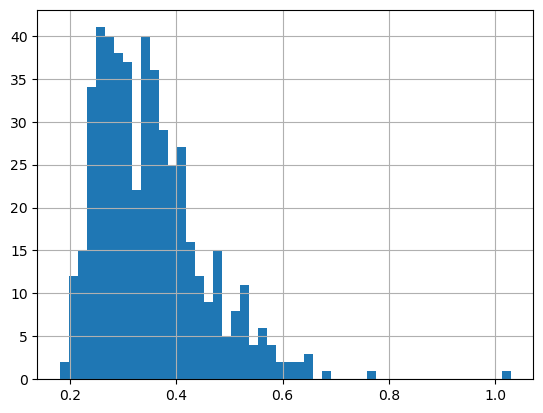

In [19]:
_ = plt.figure()
_ = df_summary['Loss_Source0_Training'].hist(bins=50)
_ = plt.figure()
_ = df_summary['Loss_Source0_Test'].hist(bins=50)
_ = plt.figure()
_ = df_summary['Loss_Source_Training'].hist(bins=50)
_ = plt.figure()
_ = df_summary['Loss_Source_Test'].hist(bins=50)
_ = plt.figure()
_ = df_summary['Loss_Target_Training'].hist(bins=50)
_ = plt.figure()
_ = df_summary['Loss_Target_Validation'].hist(bins=50)
_ = plt.figure()
_ = df_summary['Loss_Target_Test'].hist(bins=50)


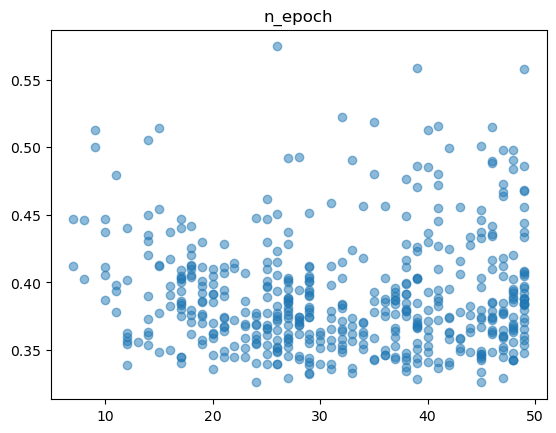

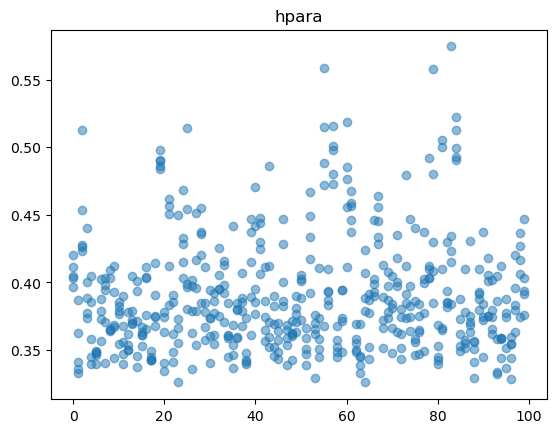

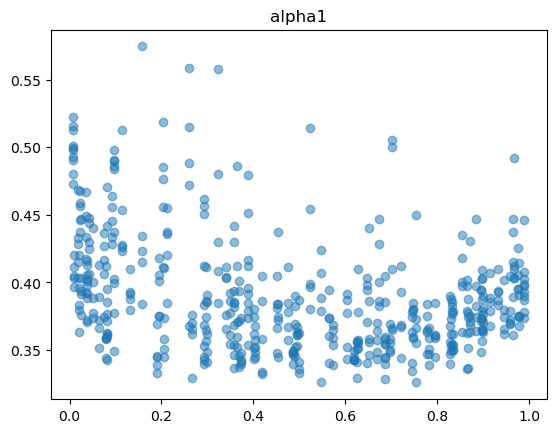

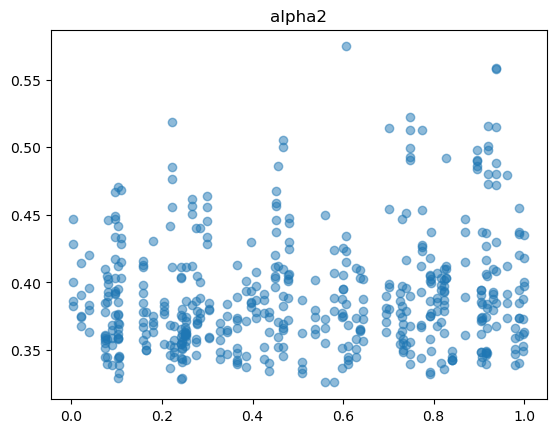

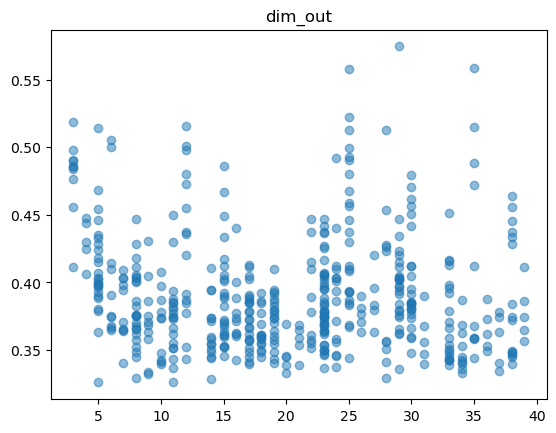

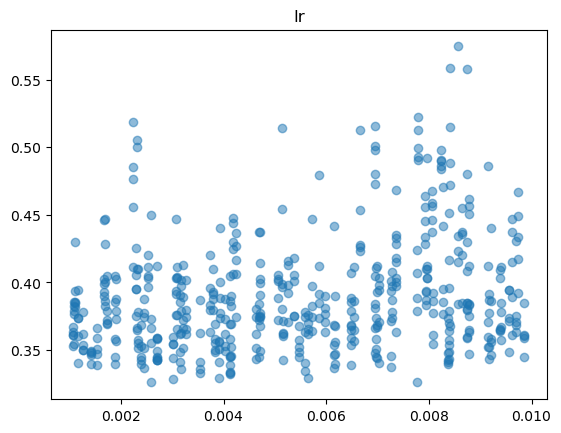

In [20]:
tar_prop = 'Loss_Source0_Test'
for col, vec_col in df_summary.iloc[:,-6:].iteritems():
    _ = plt.figure()
    _ = plt.scatter(vec_col.values, df_summary[tar_prop].values, alpha=0.5)
    _ = plt.title(col)
    

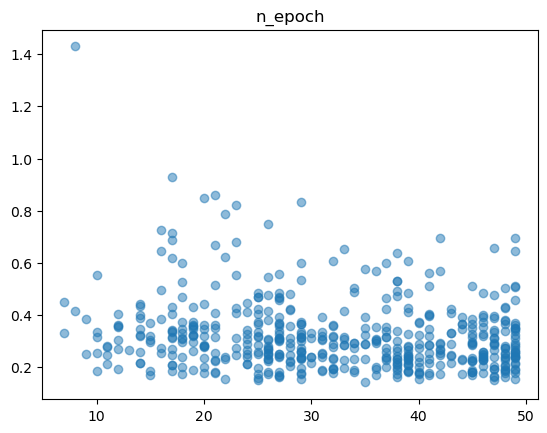

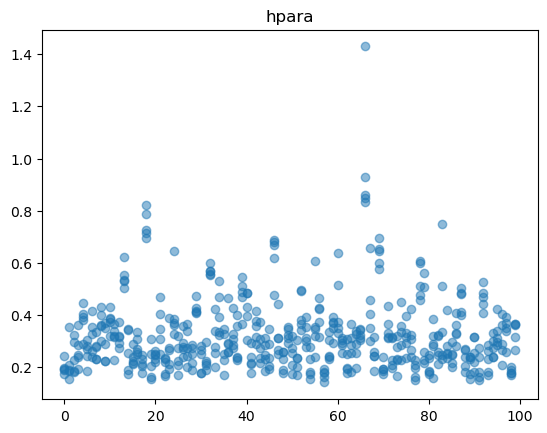

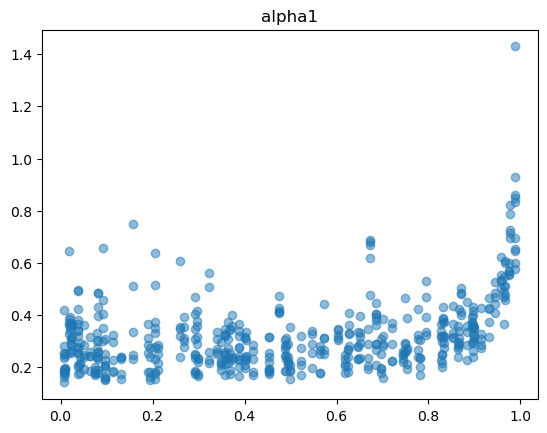

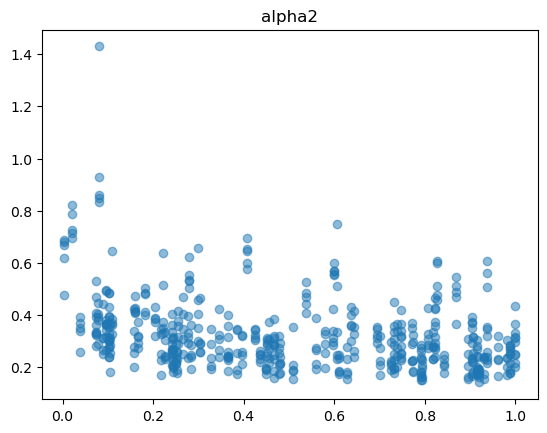

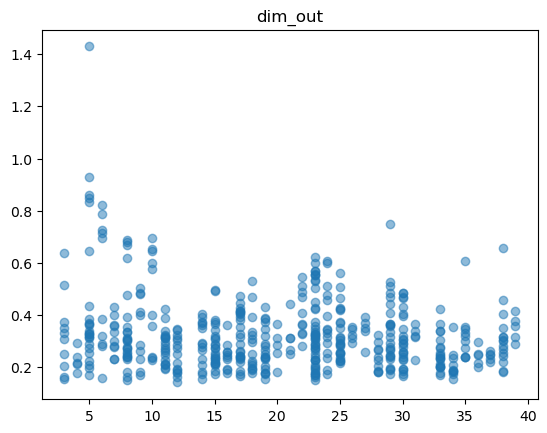

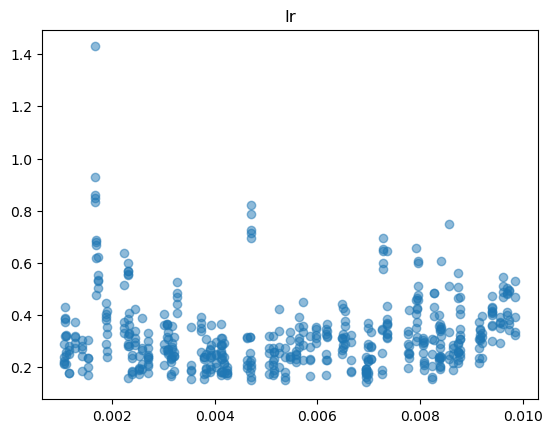

In [21]:
tar_prop = 'Loss_Source_Test'
for col, vec_col in df_summary.iloc[:,-6:].iteritems():
    _ = plt.figure()
    _ = plt.scatter(vec_col.values, df_summary[tar_prop].values, alpha=0.5)
    _ = plt.title(col)
    

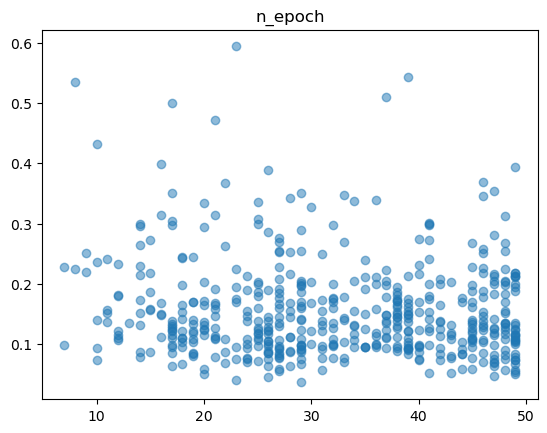

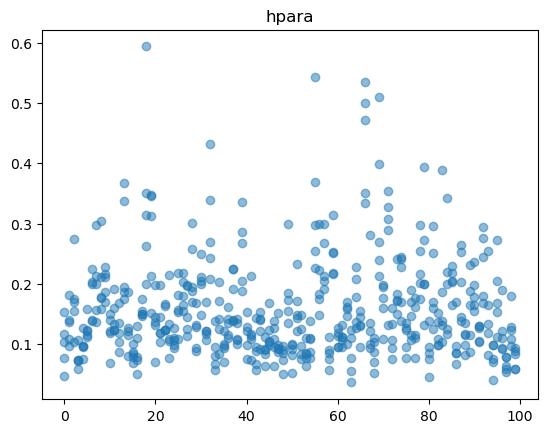

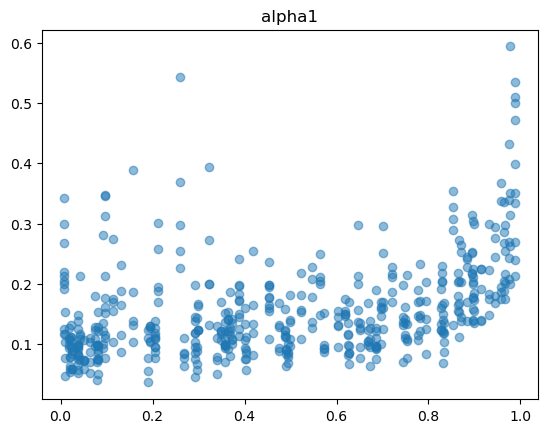

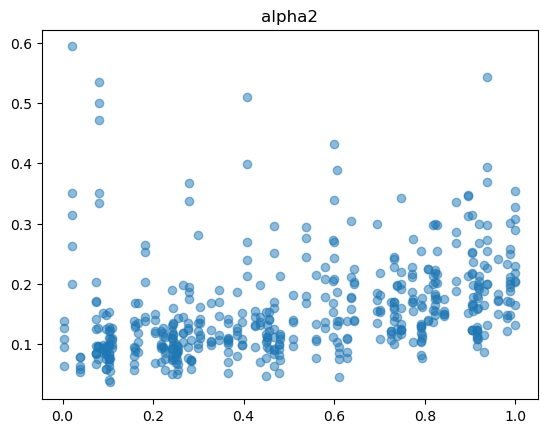

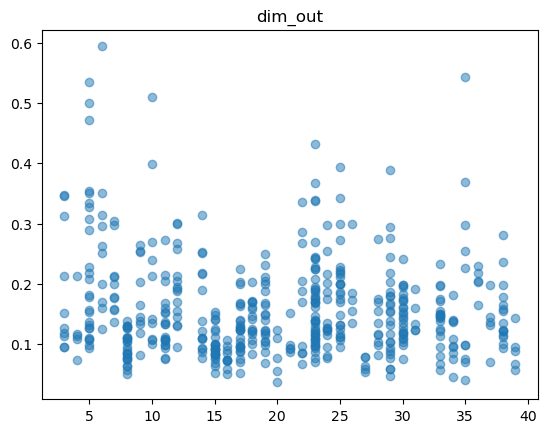

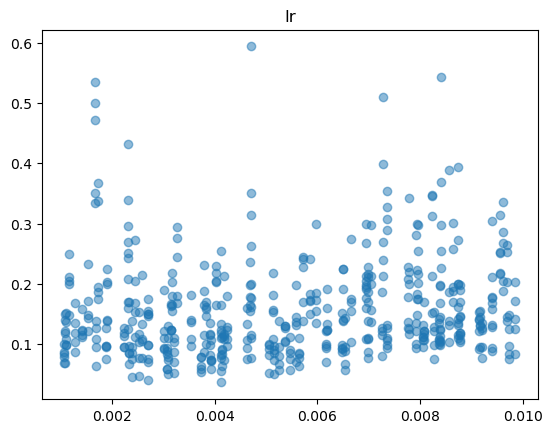

In [22]:
tar_prop = 'Loss_Target_Training'
for col, vec_col in df_summary.iloc[:,-6:].iteritems():
    _ = plt.figure()
    _ = plt.scatter(vec_col.values, df_summary[tar_prop].values, alpha=0.5)
    _ = plt.title(col)
    

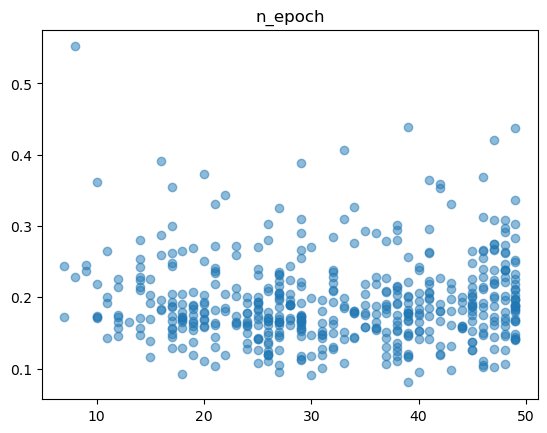

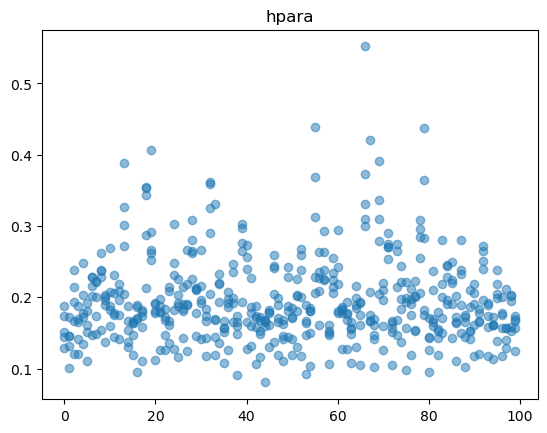

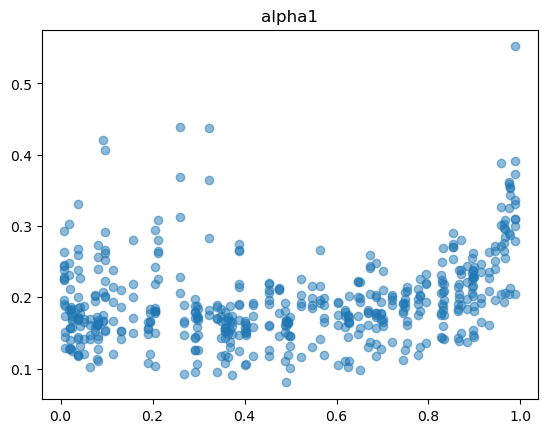

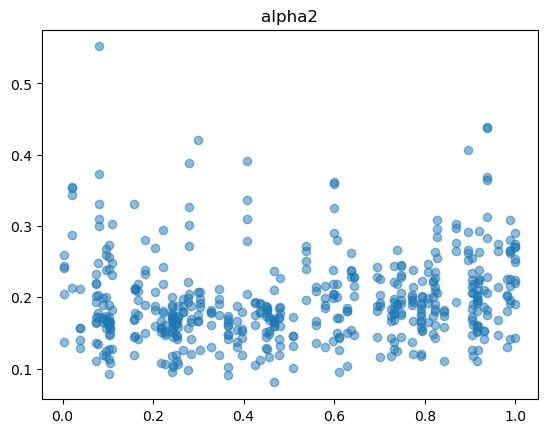

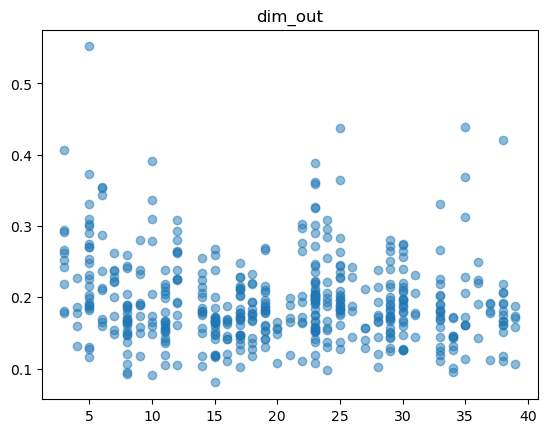

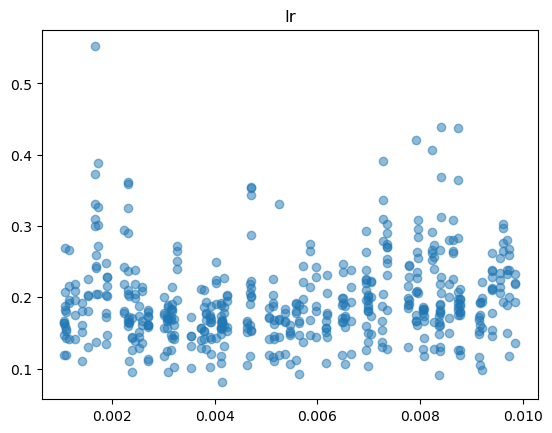

In [23]:
tar_prop = 'Loss_Target_Validation'
for col, vec_col in df_summary.iloc[:,-6:].iteritems():
    _ = plt.figure()
    _ = plt.scatter(vec_col.values, df_summary[tar_prop].values, alpha=0.5)
    _ = plt.title(col)
    

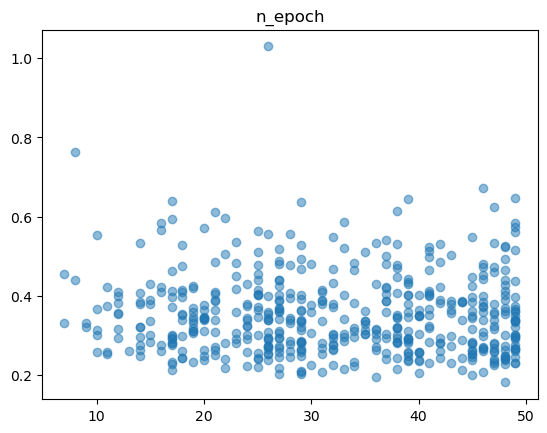

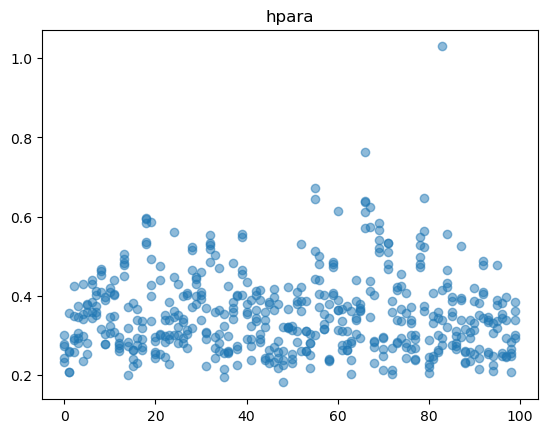

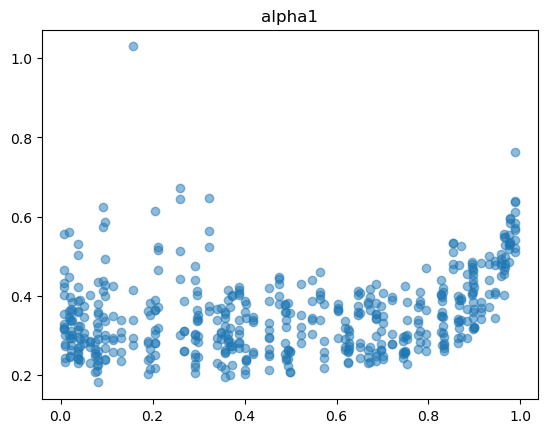

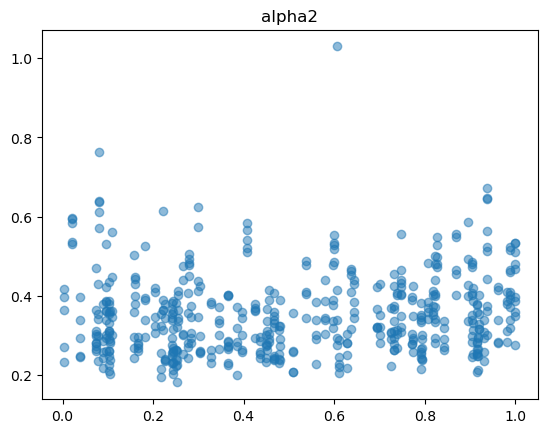

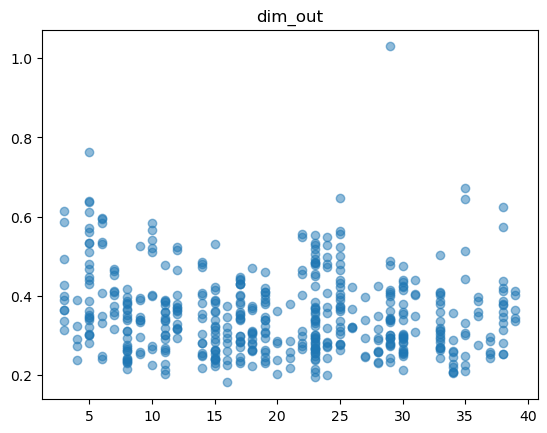

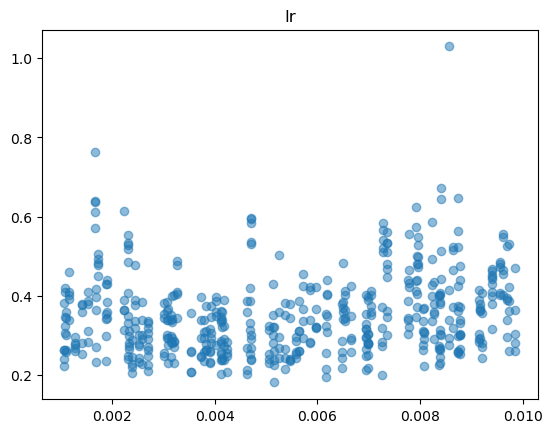

In [24]:
tar_prop = 'Loss_Target_Test'
for col, vec_col in df_summary.iloc[:,-6:].iteritems():
    _ = plt.figure()
    _ = plt.scatter(vec_col.values, df_summary[tar_prop].values, alpha=0.5)
    _ = plt.title(col)
    

### Final model training

In [25]:
dir_base2 = 'final_models/' + dir_base.split('/')[1]
os.makedirs(dir_base2, exist_ok=True)

poly_group = data_Chi.loc[idx_split_t['idx_tr'],'ps_pair']

gp_split = GroupShuffleSplit(n_splits=n_final_model, test_size=test_ratio_final, random_state=0)
idx_trs_fin, idx_vals_fin = [], []

for idx_tr, idx_val in gp_split.split(y_t['y'].loc[idx_split_t['idx_tr']], groups=poly_group.to_list()):
    idx_trs_fin.append(y_t['y'].loc[idx_split_t['idx_tr']].iloc[idx_tr].index.values)
    idx_vals_fin.append(y_t['y'].loc[idx_split_t['idx_tr']].iloc[idx_val].index.values)


In [26]:
tmp_best_para = df_summary.groupby('hpara').median().sort_values('Loss_Target_Validation').iloc[0,:][['alpha1', 'alpha2', 'dim_out', 'lr']]
alpha1 = tmp_best_para['alpha1']
alpha2 = tmp_best_para['alpha2']
dim_out = int(tmp_best_para['dim_out'])
learning_rate = tmp_best_para['lr']

alpha1, alpha2, dim_out, learning_rate


(0.2931683323752638, 0.6113281439655812, 34, 0.0023990303723315)

In [27]:
%%time

np.random.seed(0)

for iCV, (idx_tr, idx_val) in enumerate(zip(idx_trs_fin, idx_vals_fin)):
    XT_P_TR = torch.tensor(desc_t_s.loc[idx_tr, dname_p].values.astype("float"), dtype=torch.float32, device=cuda_opt)
    XT_S_TR = torch.tensor(desc_t_s.loc[idx_tr, dname_s].values.astype("float"), dtype=torch.float32, device=cuda_opt)
    XT_T_TR = torch.tensor(temp_t_s.loc[idx_tr, :].values.astype("float"), dtype=torch.float32, device=cuda_opt)
    YT_TR = torch.tensor(y_t_s.loc[idx_tr, :].values.astype("float"), dtype=torch.float32, device=cuda_opt)

    XT_P_VA = torch.tensor(desc_t_s.loc[idx_val, dname_p].values.astype("float"), dtype=torch.float32, device=cuda_opt)
    XT_S_VA = torch.tensor(desc_t_s.loc[idx_val, dname_s].values.astype("float"), dtype=torch.float32, device=cuda_opt)
    XT_T_VA = torch.tensor(temp_t_s.loc[idx_val, :].values.astype("float"), dtype=torch.float32, device=cuda_opt)
    YT_VA = torch.tensor(y_t_s.loc[idx_val, :].values.astype("float"), dtype=torch.float32, device=cuda_opt)

    generator_p = ParameterGenerator(
        in_features=dim_in_p,
        out_features=dim_out*2,
        h_neurons=dict(
            data=lambda x: neuron_vector(x, dim_in_p, dim_out*2), 
            repeat=[n_NNlayer]
        ),
        h_activation_funcs=(nn.Sigmoid(), ),
        h_dropouts=(0.0,)
    )

    generator_s = ParameterGenerator(
        in_features=dim_in_s,
        out_features=dim_out*2,
        h_neurons=dict(
            data=lambda x: neuron_vector(x, dim_in_s, dim_out*2), 
            repeat=[n_NNlayer]
        ),
        h_activation_funcs=(nn.Sigmoid(), ),
        h_dropouts=(0.0,)
    )

    for iM, ((paras_p, model_p), (paras_s, model_s)) in enumerate(zip(generator_p(num=1, factory=SequentialLinear), generator_s(num=1, factory=SequentialLinear))):
        dir_save = f'{dir_base2}/model_{iCV}'
        os.makedirs(dir_save, exist_ok=True)

        c_model = Chi_Model(model_p, model_s, dim_out)
        c_model.to(cuda_opt)

        c_model.train()

        optimizer = optim.Adam(c_model.parameters(), lr=learning_rate, amsgrad=True)
        scheduler = StepLR(optimizer, step_size=sch_step_size, gamma=sch_gamma)

        learning_curve = pd.DataFrame()

        for t in range(epochs_s):
            # mini-batch of training data
            kf = KFold(n_splits=n_minibatch_PI, shuffle=True)
            idx_mb_s0 = [x for _, x in kf.split(XS0_P_TR)]

            # pre-training with PI
            for tt, ii_s0 in enumerate(idx_mb_s0):
                c_model.train()

                tmp_source0_train = c_model(XS0_P_TR[ii_s0,:], XS0_S_TR[ii_s0,:], XS0_T_TR[ii_s0,:])
                py_source0_train = tmp_source0_train[:,0:1]
                loss_source0_train = criterion_source0(py_source0_train, YS0_TR[ii_s0,:])

                optimizer.zero_grad()
                loss_source0_train.backward()
                optimizer.step()

                c_model.eval()
                with torch.no_grad():
                    py_source_train = c_model(XS_P_TR, XS_S_TR, XS_T_TR)[:,1:2]
                    py_target_train = c_model(XT_P_TR, XT_S_TR, XT_T_TR)[:,2:3]
                    loss_source_train = criterion_source(py_source_train, YS_TR)
                    loss_target_train = criterion_target(py_target_train, YT_TR)*loss_factor_target
                    loss_train = alpha1*loss_source0_train + (1.0-alpha1)*(alpha2*loss_source_train + (1.0-alpha2)*loss_target_train)

                    py_target_val = c_model(XT_P_VA, XT_S_VA, XT_T_VA)[:,1:2]
                    loss_target_val = criterion_target(py_target_val, YT_VA)*loss_factor_target

                    py_source0_test = c_model(XS0_P_TE, XS0_S_TE, XS0_T_TE)[:,0:1]
                    py_source_test = c_model(XS_P_TE, XS_S_TE, XS_T_TE)[:,1:2]
                    py_target_test = c_model(XT_P_TE, XT_S_TE, XT_T_TE)[:,2:3]
                    loss_source0_test = criterion_source0(py_source0_test, YS0_TE)
                    loss_source_test = criterion_source(py_source_test, YS_TE)
                    loss_target_test = criterion_target(py_target_test, YT_TE)*loss_factor_target
                    loss_test = alpha1*loss_source0_test + (1.0-alpha1)*(alpha2*loss_source_test + (1.0-alpha2)*loss_target_test)

                learning_curve = pd.concat([learning_curve, pd.Series({
                                        "Loss_Source0_Training": loss_source0_train.item(), 
                                        "Loss_Source0_Test": loss_source0_test.item(),
                                        "Loss_Source_Training": loss_source_train.item(), 
                                        "Loss_Source_Test": loss_source_test.item(),
                                        "Loss_Target_Training": loss_target_train.item(),
                                        "Loss_Target_Validation":loss_target_val.item(),
                                        "Loss_Target_Test":loss_target_test.item(),
                                        "Loss_Training":loss_train.item(),
                                        "Loss_Test":loss_test.item()},
                                       name=f'pre_{t}').to_frame().T], axis=0)

        # main training
        best_loss_val = np.inf
        for t in range(epochs):
            # mini-batch of training data
            kf = KFold(n_splits=n_minibatch_PI, shuffle=True)
            idx_mb_s0 = [x for _, x in kf.split(XS0_P_TR)]
            idx_mb_s, idx_mb_t = [], []
            for k in range(n_factor_COSMO):
                kf = KFold(n_splits=n_minibatch_COSMO, shuffle=True)
                idx_mb_s += [x for _, x in kf.split(XS_P_TR)]
            for k in range(n_factor_CHI):
                kf = KFold(n_splits=n_minibatch_CHI, shuffle=True)
                idx_mb_t += [x for _, x in kf.split(XT_P_TR)]

            for tt, (ii_s0, ii_s, ii_t) in enumerate(zip(idx_mb_s0, idx_mb_s, idx_mb_t)):
                c_model.train()
                if alpha1 > 0:
                    py_source0_train = c_model(XS0_P_TR[ii_s0,:], XS0_S_TR[ii_s0,:], XS0_T_TR[ii_s0,:])[:,0:1]
                    loss_source0_train = criterion_source0(py_source0_train, YS0_TR[ii_s0,:])
                else:
                    loss_source0_train = torch.zeros(1, device=cuda_opt)

                if (alpha2 > 0) and (alpha1 < 1):
                    if no_COSMO_BN:
                        c_model.eval()
                    else:
                        c_model.train()
                    py_source_train = c_model(XS_P_TR[ii_s,:], XS_S_TR[ii_s,:], XS_T_TR[ii_s,:])[:,1:2]
                    loss_source_train = criterion_source(py_source_train, YS_TR[ii_s,:])
                else:
                    loss_source_train = torch.zeros(1, device=cuda_opt)

                if (alpha1 < 1) and (alpha2 < 1):
                    if no_target_BN:
                        c_model.eval()
                    else:
                        c_model.train()
                    py_target_train = c_model(XT_P_TR[ii_t,:], XT_S_TR[ii_t,:], XT_T_TR[ii_t,:])[:,2:3]
                    loss_target_train = criterion_target(py_target_train, YT_TR[ii_t,:])*loss_factor_target
                else:
                    loss_target_train = torch.zeros(1, device=cuda_opt)

                loss_train = alpha1*loss_source0_train + (1.0-alpha1)*(alpha2*loss_source_train + (1.0-alpha2)*loss_target_train)

                optimizer.zero_grad()
                loss_train.backward()
                optimizer.step()

                c_model.eval()
                with torch.no_grad():
                    py_target_val = c_model(XT_P_VA, XT_S_VA, XT_T_VA)[:,2:3]
                    loss_target_val = criterion_target(py_target_val, YT_VA)*loss_factor_target

                    py_source0_test = c_model(XS0_P_TE, XS0_S_TE, XS0_T_TE)[:,0:1]
                    py_source_test = c_model(XS_P_TE, XS_S_TE, XS_T_TE)[:,1:2]
                    py_target_test = c_model(XT_P_TE, XT_S_TE, XT_T_TE)
                    loss_source0_test = criterion_source0(py_source0_test, YS0_TE)
                    loss_source_test = criterion_source(py_source_test, YS_TE)
                    loss_target_test = criterion_target(py_target_test[:,2:3], YT_TE)*loss_factor_target
                    loss_test = alpha1*loss_source0_test + (1.0-alpha1)*(alpha2*loss_source_test + (1.0-alpha2)*loss_target_test)

                learning_curve = pd.concat([learning_curve, pd.Series({
                                        "Loss_Source0_Training": loss_source0_train.item(), 
                                        "Loss_Source0_Test": loss_source0_test.item(),
                                        "Loss_Source_Training": loss_source_train.item(), 
                                        "Loss_Source_Test": loss_source_test.item(),
                                        "Loss_Target_Training": loss_target_train.item(),
                                        "Loss_Target_Validation":loss_target_val.item(),
                                        "Loss_Target_Test":loss_target_test.item(),
                                        "Loss_Training":loss_train.item(),
                                        "Loss_Test":loss_test.item()},
                                       name=f'main_{t}_{tt}').to_frame().T], axis=0)

                if (t > burn_in) and (loss_target_val < best_loss_val):
                    save_NN(paras_p, paras_s, dim_out, c_model, f'{dir_save}/best_loss_target_val.pt')

                    with torch.no_grad():
                        py_source0_train = c_model(XS0_P_TR, XS0_S_TR, XS0_T_TR)[:,0:1]
                        py_source_train = c_model(XS_P_TR, XS_S_TR, XS_T_TR)[:,1:2]
                        py_target_train = c_model(XT_P_TR, XT_S_TR, XT_T_TR)[:,2:3]
                    pd.concat([y_s0.loc[idx_split_s0['idx_tr'],:], pd.Series(py_source0_train.to('cpu').detach().numpy().flatten(), index=idx_split_s0['idx_tr'], name='pred')] , axis=1
                             ).to_csv(f'{dir_save}/best_loss_target_val_source0_train.csv')
                    pd.concat([y_s.loc[idx_split_s['idx_tr'],:], pd.Series(ys_scaler.inverse_transform(py_source_train.to('cpu').detach().numpy()).flatten(), index=idx_split_s['idx_tr'], name='pred')] , axis=1
                             ).to_csv(f'{dir_save}/best_loss_target_val_source_train.csv')
                    pd.concat([y_t.loc[idx_tr,:], pd.Series(yt_scaler.inverse_transform(py_target_train.to('cpu').detach().numpy()).flatten(), index=idx_tr, name='pred')] , axis=1
                             ).to_csv(f'{dir_save}/best_loss_target_val_target_train.csv')

                    pd.concat([y_t.loc[idx_val,:], pd.Series(yt_scaler.inverse_transform(py_target_val.to('cpu').detach().numpy()).flatten(), index=idx_val, name='pred')] , axis=1
                             ).to_csv(f'{dir_save}/best_loss_target_val_target_val.csv')

                    pd.concat([y_s0.loc[idx_split_s0['idx_te'],:], pd.Series(py_source0_test.to('cpu').detach().numpy().flatten(), index=idx_split_s0['idx_te'], name='pred')] , axis=1
                             ).to_csv(f'{dir_save}/best_loss_target_val_source0_test.csv')
                    pd.concat([y_s.loc[idx_split_s['idx_te'],:], pd.Series(ys_scaler.inverse_transform(py_source_test.to('cpu').detach().numpy()).flatten(), index=idx_split_s['idx_te'], name='pred')] , axis=1
                             ).to_csv(f'{dir_save}/best_loss_target_val_source_test.csv')
                    pd.concat([y_t.loc[idx_split_t['idx_te'],:], pd.Series(yt_scaler.inverse_transform(py_target_test[:,2:3].to('cpu').detach().numpy()).flatten(), index=idx_split_t['idx_te'], name='pred')] , axis=1
                             ).to_csv(f'{dir_save}/best_loss_target_val_target_test.csv')
                    
                    tmp_mat = py_target_test.to('cpu').detach().numpy()
                    tmp_mat[:,1:2] = ys_scaler.inverse_transform(tmp_mat[:,1:2])
                    tmp_mat[:,2:3] = yt_scaler.inverse_transform(tmp_mat[:,2:3])
                    tmp_mat = pd.DataFrame(tmp_mat)
                    tmp_mat.columns = ['Soluble', 'Chi_COSMO', 'Chi_Exp', 'Z_sol', 'A_COSMO', 'B_COSMO', 'A_Exp', 'B_Exp'] + [f'Z_{x}' for x in range(dim_out)]
                    tmp_mat.to_csv(f'{dir_save}/output_target_test.csv')

                    best_loss_val = loss_target_val

            scheduler.step()

        learning_curve.to_csv(f'{dir_save}/learning_curve.csv')

    print(f'Finished model {iCV}')


Finished model 0
Finished model 1
Finished model 2
Finished model 3
Finished model 4
Finished model 5
Finished model 6
Finished model 7
Finished model 8
Finished model 9
CPU times: user 5min 20s, sys: 11.5 s, total: 5min 31s
Wall time: 4min 20s


In [13]:
import torch

# Load the state dict from the saved .pt file
model_path = '/home/lulab/Projects/ml_for_polymer/MTL_Chi/final_models/MT_testset_1/model_0/best_loss_target_val.pt'
state_dict = torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Print out the keys to inspect the model's structure
for key in state_dict.keys():
    print(key)

# Function to recursively print shapes of all tensors in the state_dict
def print_state_dict_shapes(state_dict, parent_key=''):
    for key, value in state_dict.items():
        full_key = f"{parent_key}.{key}" if parent_key else key
        if isinstance(value, dict):
            print_state_dict_shapes(value, parent_key=full_key)
        else:
            try:
                print(f"{full_key}: {value.shape}")
            except AttributeError:
                print(f"{full_key} (Not a tensor, type: {type(value)})")

# Print out the keys and their shapes
print_state_dict_shapes(state_dict)


model_p
model_s
chi
dim_out
model_p.in_features (Not a tensor, type: <class 'int'>)
model_p.out_features (Not a tensor, type: <class 'int'>)
model_p.h_activation_funcs (Not a tensor, type: <class 'torch.nn.modules.activation.Sigmoid'>)
model_p.h_dropouts (Not a tensor, type: <class 'float'>)
model_p.h_neurons (Not a tensor, type: <class 'tuple'>)
model_s.in_features (Not a tensor, type: <class 'int'>)
model_s.out_features (Not a tensor, type: <class 'int'>)
model_s.h_activation_funcs (Not a tensor, type: <class 'torch.nn.modules.activation.Sigmoid'>)
model_s.h_dropouts (Not a tensor, type: <class 'float'>)
model_s.h_neurons (Not a tensor, type: <class 'tuple'>)
chi.network1.layer_0.linear.weight: torch.Size([264, 330])
chi.network1.layer_0.linear.bias: torch.Size([264])
chi.network1.layer_0.normalizer.weight: torch.Size([264])
chi.network1.layer_0.normalizer.bias: torch.Size([264])
chi.network1.layer_0.normalizer.running_mean: torch.Size([264])
chi.network1.layer_0.normalizer.running_v

/tmp/ipykernel_9446/1250216841.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_avai

In [3]:
import torch
import torch.nn as nn
from copy import deepcopy
import numpy as np
from xenonpy.model import SequentialLinear

# Define the model class based on temp_dim
class Chi_Model(nn.Module):
    def __init__(self, sp_mdl_p, sp_mdl_s, dim_ur, temp_dim):
        super(Chi_Model, self).__init__()

        self.network1 = deepcopy(sp_mdl_p)
        self.network2 = deepcopy(sp_mdl_s)

        if temp_dim == 1:
            self.out_lin = nn.Linear(dim_ur, 5)
            self.out_act = nn.Sigmoid()
            self.dim_ur = dim_ur
        elif temp_dim == 2:
            self.out_lin = nn.Linear(dim_ur, 7)
            self.out_act = nn.Sigmoid()
            self.dim_ur = dim_ur

    def forward(self, x1, x2, temp):
        ur1 = self.network1(x1)
        ur2 = self.network2(x2)

        sp = (ur1[:,:self.dim_ur] - ur2[:,:self.dim_ur])**2
        r1 = ur1[:,self.dim_ur:]**2
        r2 = ur2[:,self.dim_ur:]**2

        z0 = sp - r1 - r2
        z = self.out_lin(z0)

        z_soluble = self.out_act(z[:,0:1])

        if self.out_lin.out_features == 5:  # For temp_dim == 1
            As = z[:,1:2]
            Bs = z[:,2:3]
            z_comp = As + Bs*temp[:,0:1]

            At = z[:,3:4]
            Bt = z[:,4:5]
            z_target = At + Bt*temp[:,0:1]
        elif self.out_lin.out_features == 7:  # For temp_dim == 2
            As = z[:,1:2]
            Bs = z[:,2:3]
            Cs = z[:,3:4]
            z_comp = As + Bs*temp[:,0:1] + Cs*temp[:,1:2]

            At = z[:,4:5]
            Bt = z[:,5:6]
            Ct = z[:,6:7]
            z_target = At + Bt*temp[:,0:1] + Ct*temp[:,1:2]

        y = torch.cat((z_soluble, z_comp, z_target, z, z0), dim=1)

        return y

# functions to save and load the NN model
def save_NN(paras_p, paras_s, dim_out, c_mdl, file_name):
    torch.save({'model_p': paras_p, 'model_s': paras_s, 'chi': c_mdl.state_dict(), 'dim_out': dim_out}, file_name)
    
def load_NN(file_name):
    tmp_paras = torch.load(file_name)
    c_model = Chi_Model(SequentialLinear(**tmp_paras['model_p']), SequentialLinear(**tmp_paras['model_s']), tmp_paras['dim_out'],temp_dim=1)
    _ = c_model.load_state_dict(tmp_paras['chi'])
    return c_model

# For this example, we're using dummy data. Replace these with your actual data.
num_samples = 1  # Number of samples in your batch
dim_polymer = 330  # Example dimension of polymer input features
dim_solvent = 337  # Example dimension of solvent input features
temp_dim = 1  # Temperature dimension (1 or 2)

# Dummy data (replace with your actual data)
x1_numpy = np.random.rand(num_samples, dim_polymer).astype(np.float32)  # Polymer input tensor
x2_numpy = np.random.rand(num_samples, dim_solvent).astype(np.float32)  # Solvent input tensor
temp_numpy = np.random.rand(num_samples, temp_dim).astype(np.float32)  # Temperature tensor

# Convert numpy arrays to PyTorch tensors
x1 = torch.tensor(x1_numpy, dtype=torch.float32)
x2 = torch.tensor(x2_numpy, dtype=torch.float32)
temp = torch.tensor(temp_numpy, dtype=torch.float32)

model = load_NN('/home/lulab/Projects/ml_for_polymer/MTL_Chi/final_models/MT_testset_1/model_0/best_loss_target_val.pt')
model.eval()  # Set the model to evaluation mode

# Make predictions
with torch.no_grad():  # Disable gradient calculation
    output = model(x1, x2, temp)

# Print output shape
print("Output shape:", output.shape)
# Process output
print("Model output:", output)


Output shape: torch.Size([1, 42])
Model output: tensor([[ 0.6771, -0.6824, -0.5930,  0.7404, -0.5371, -0.3967, -0.5225, -0.1924,
          1.1594,  0.0135, -0.0137,  2.3801,  0.6451, -0.1391,  0.2158,  0.0698,
          0.0702,  0.5188, -0.1495,  0.0462, -0.1284, -0.0732, -0.1917, -0.2541,
         -1.3085, -0.0607, -0.1523,  0.2303, -0.0853,  0.0595,  0.0166, -0.0190,
         -0.0383,  1.2767,  0.1082,  0.3091, -0.9103,  0.0453,  0.1815,  0.2385,
          0.4299,  0.1085]])


/tmp/ipykernel_14440/1956515032.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tmp_paras = torch.load(file_name)
